# Steps
1. Choose data scenario.
2. Generate the dataset accordingly.
5. Choose 'fixed' configuration.
6. For each 'fixed' configuration, optimize the other parameters based on RMSE.
7. Given optimal setting, run popularity bias analysis for every version of the 'fixed' configuration.

## Libraries

In [1]:
import os

os.environ["MKL_THREADING_LAYER"] = "TBB"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
# for random generation


# basic functions
import pandas as pd

pd.options.display.max_rows = 100
import pickle

# custom-made functions
import modelling_mf
from data_generation import generate_data
from optimize_hp import optimize_lkpy, optimize_cornac

# lenskit RS library
from lenskit.algorithms import als


# cornac RS library
from cornac.models import MF

## Fairbook data and parameters

In [2]:
data = "fairbook"
# user-item interactions
fairbook_ratings = pd.read_csv("data/" + data + "_events.csv")

In [3]:
user_col = "user"  # the name of the column that includes the users
item_col = "item"  # the name of the column that includes the items
predict_col = "rating"  # the name of the column that includes the interaction

## Scenarios

1. There is no general relation between popularity and rating: uniformly_random
2. Popular items are rated higher by the users.: popularity_good
3. Popular items are rated lower by the users.: popilarity_bad
4. Popular items are rated higher by users with big profiles.: popularity_good_for_bp_ur
5. Popular items are rated lower by users with big profiles.: popularity_bad_for_bp_ur

In [4]:
data_strategies = [
    "uniformly_random",
    "popularity_good",
    "popularity_bad",
    "popularity_good_for_bp_ur",
    "popularity_bad_for_bp_ur",
]

## Optimize, train, evaluate LKPY
- **Algorithm**
- **Fixed parameters**
- **To-optimize parameters**

In [5]:
algo_versions = {"MF": [{"bias": True}, {"bias": False}]}

In [6]:
evaluation_way = "cross_validation"
verbose = False
plot = True
save_plot = True  # save the plots
fallback = False
nr_recs = 10
sampling_strategy = "frac"
partition_way = "user"

uniformly_random {'bias': True}
We got them already
nr of longtail 5073
3.9882075471698113
nr of longtail 5327
4.187893081761007
nr of longtail 5571
4.379716981132075
nr of longtail 5410
4.256490952006295
nr of longtail 5423
4.266719118804091


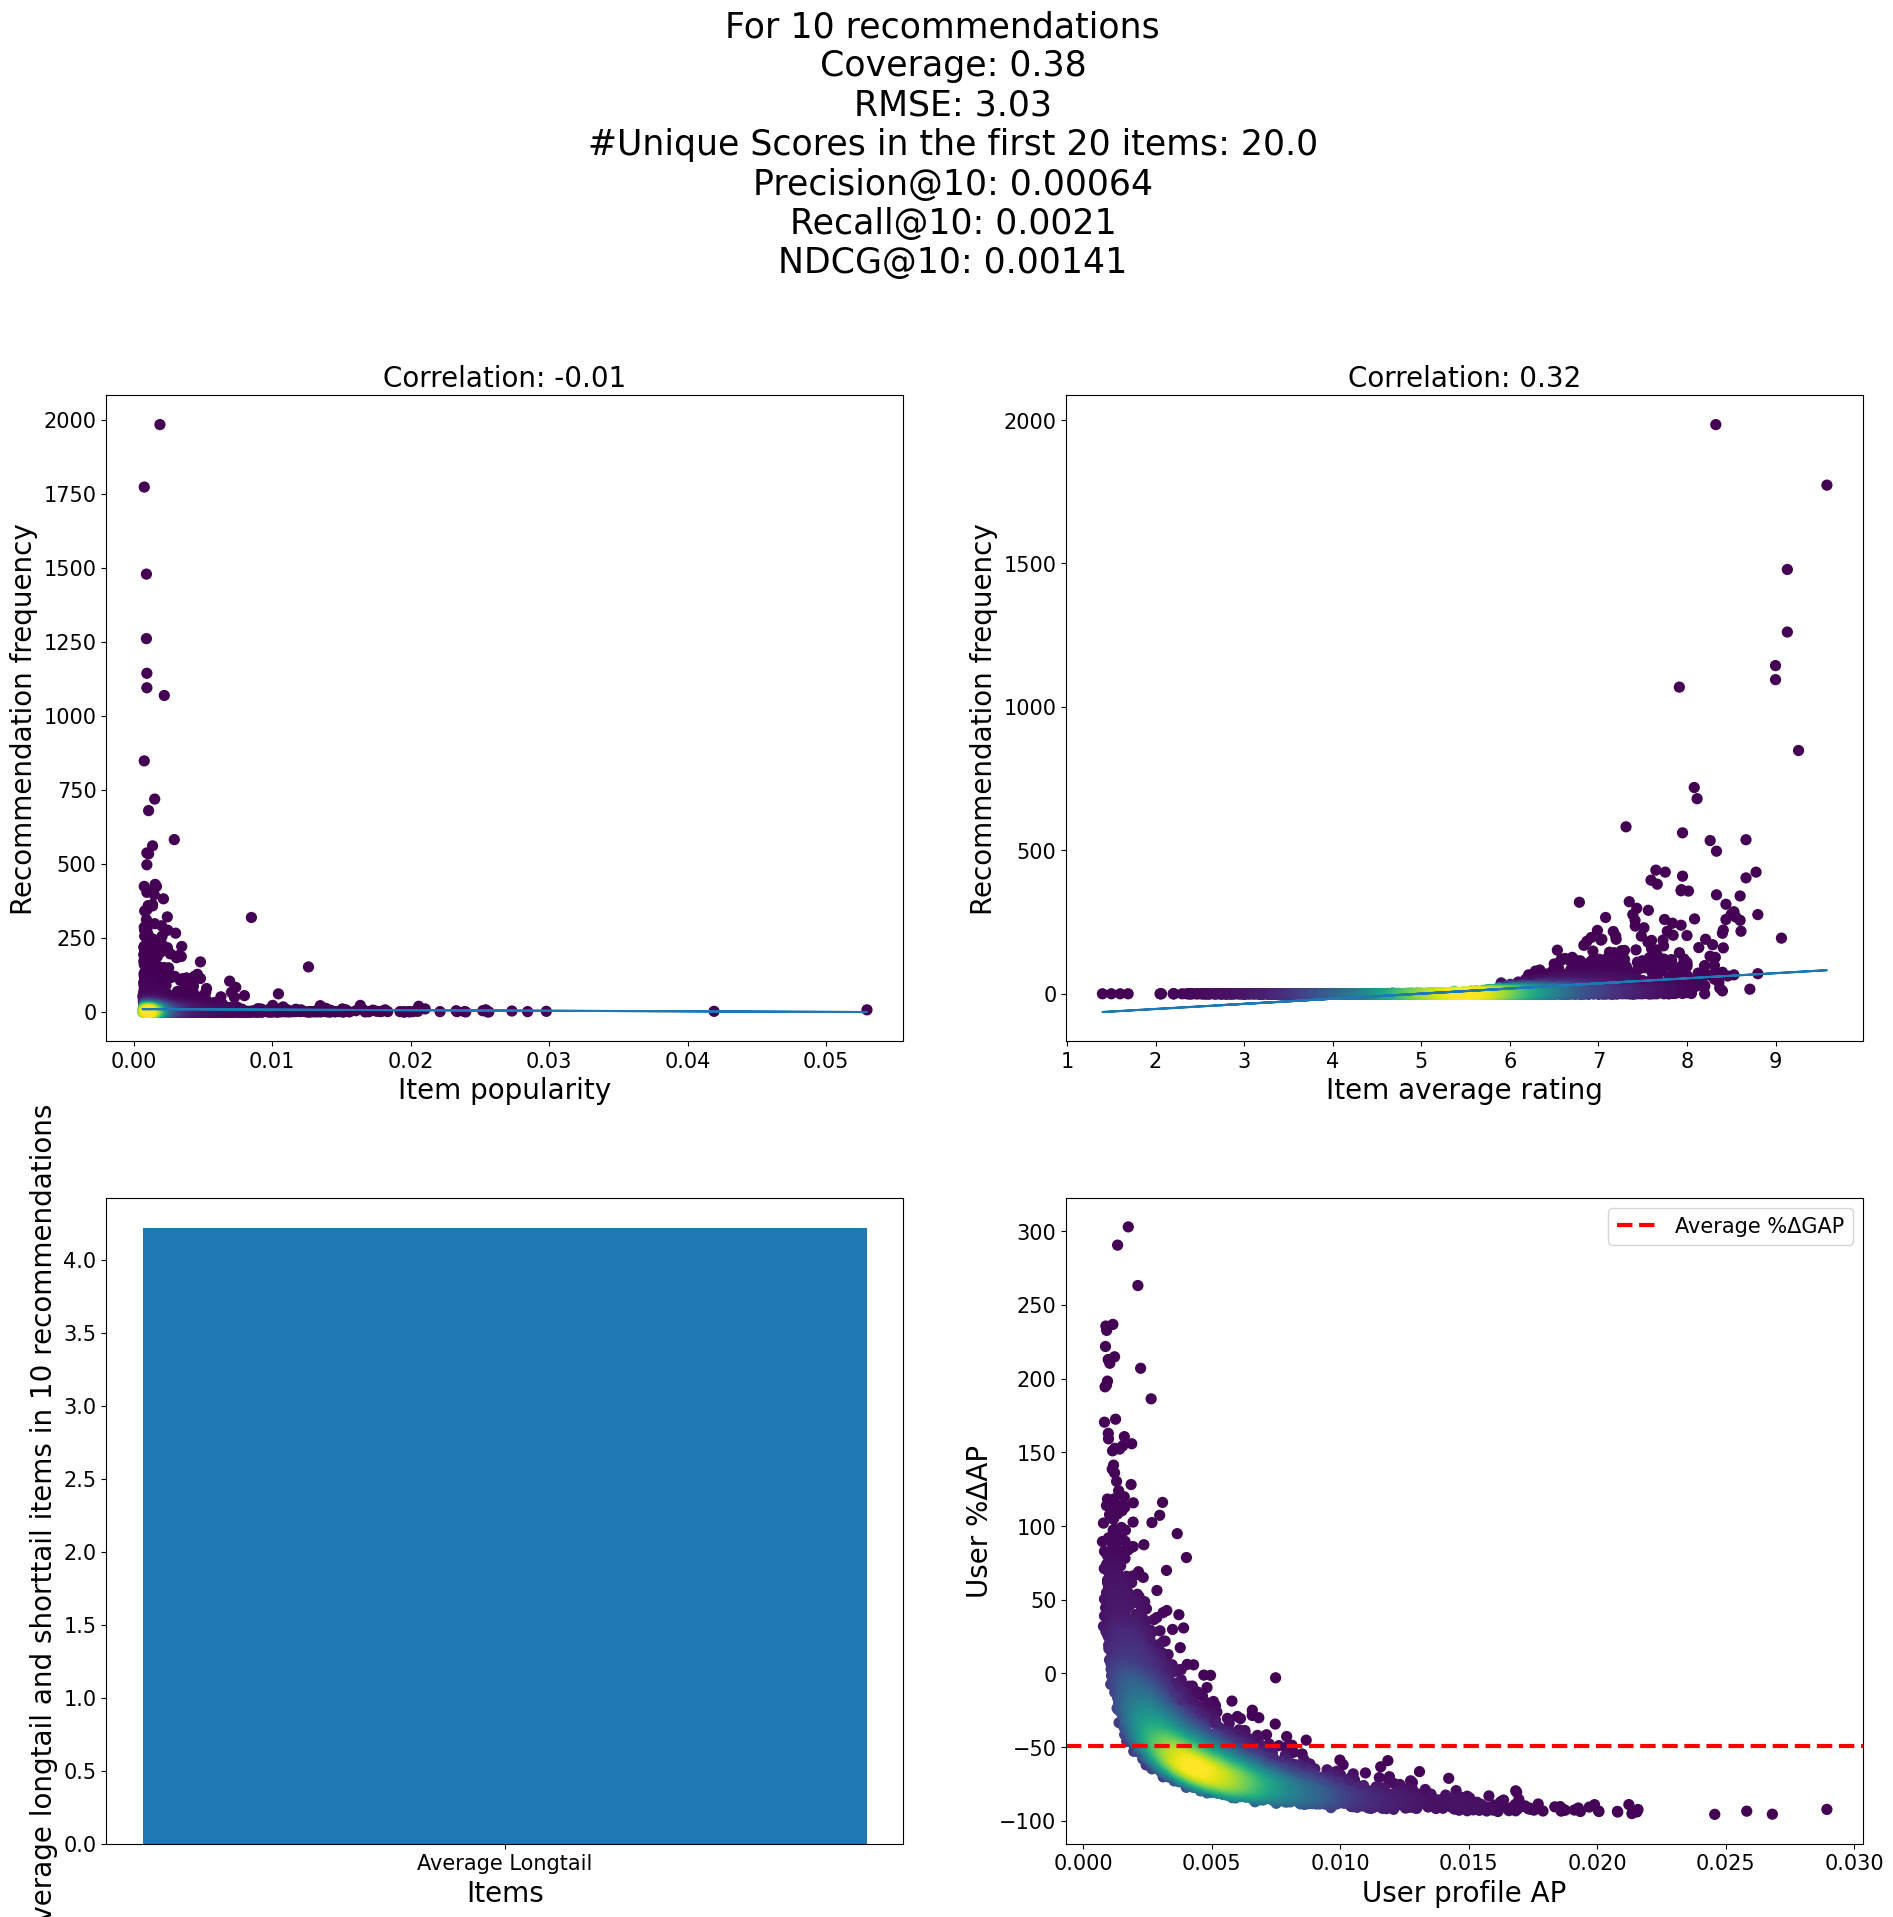

uniformly_random {'bias': False}
We got them already
nr of longtail 5915
4.6501572327044025
nr of longtail 6423
5.0495283018867925
nr of longtail 6706
5.272012578616352
nr of longtail 6575
5.17309205350118
nr of longtail 6639
5.223446105428796


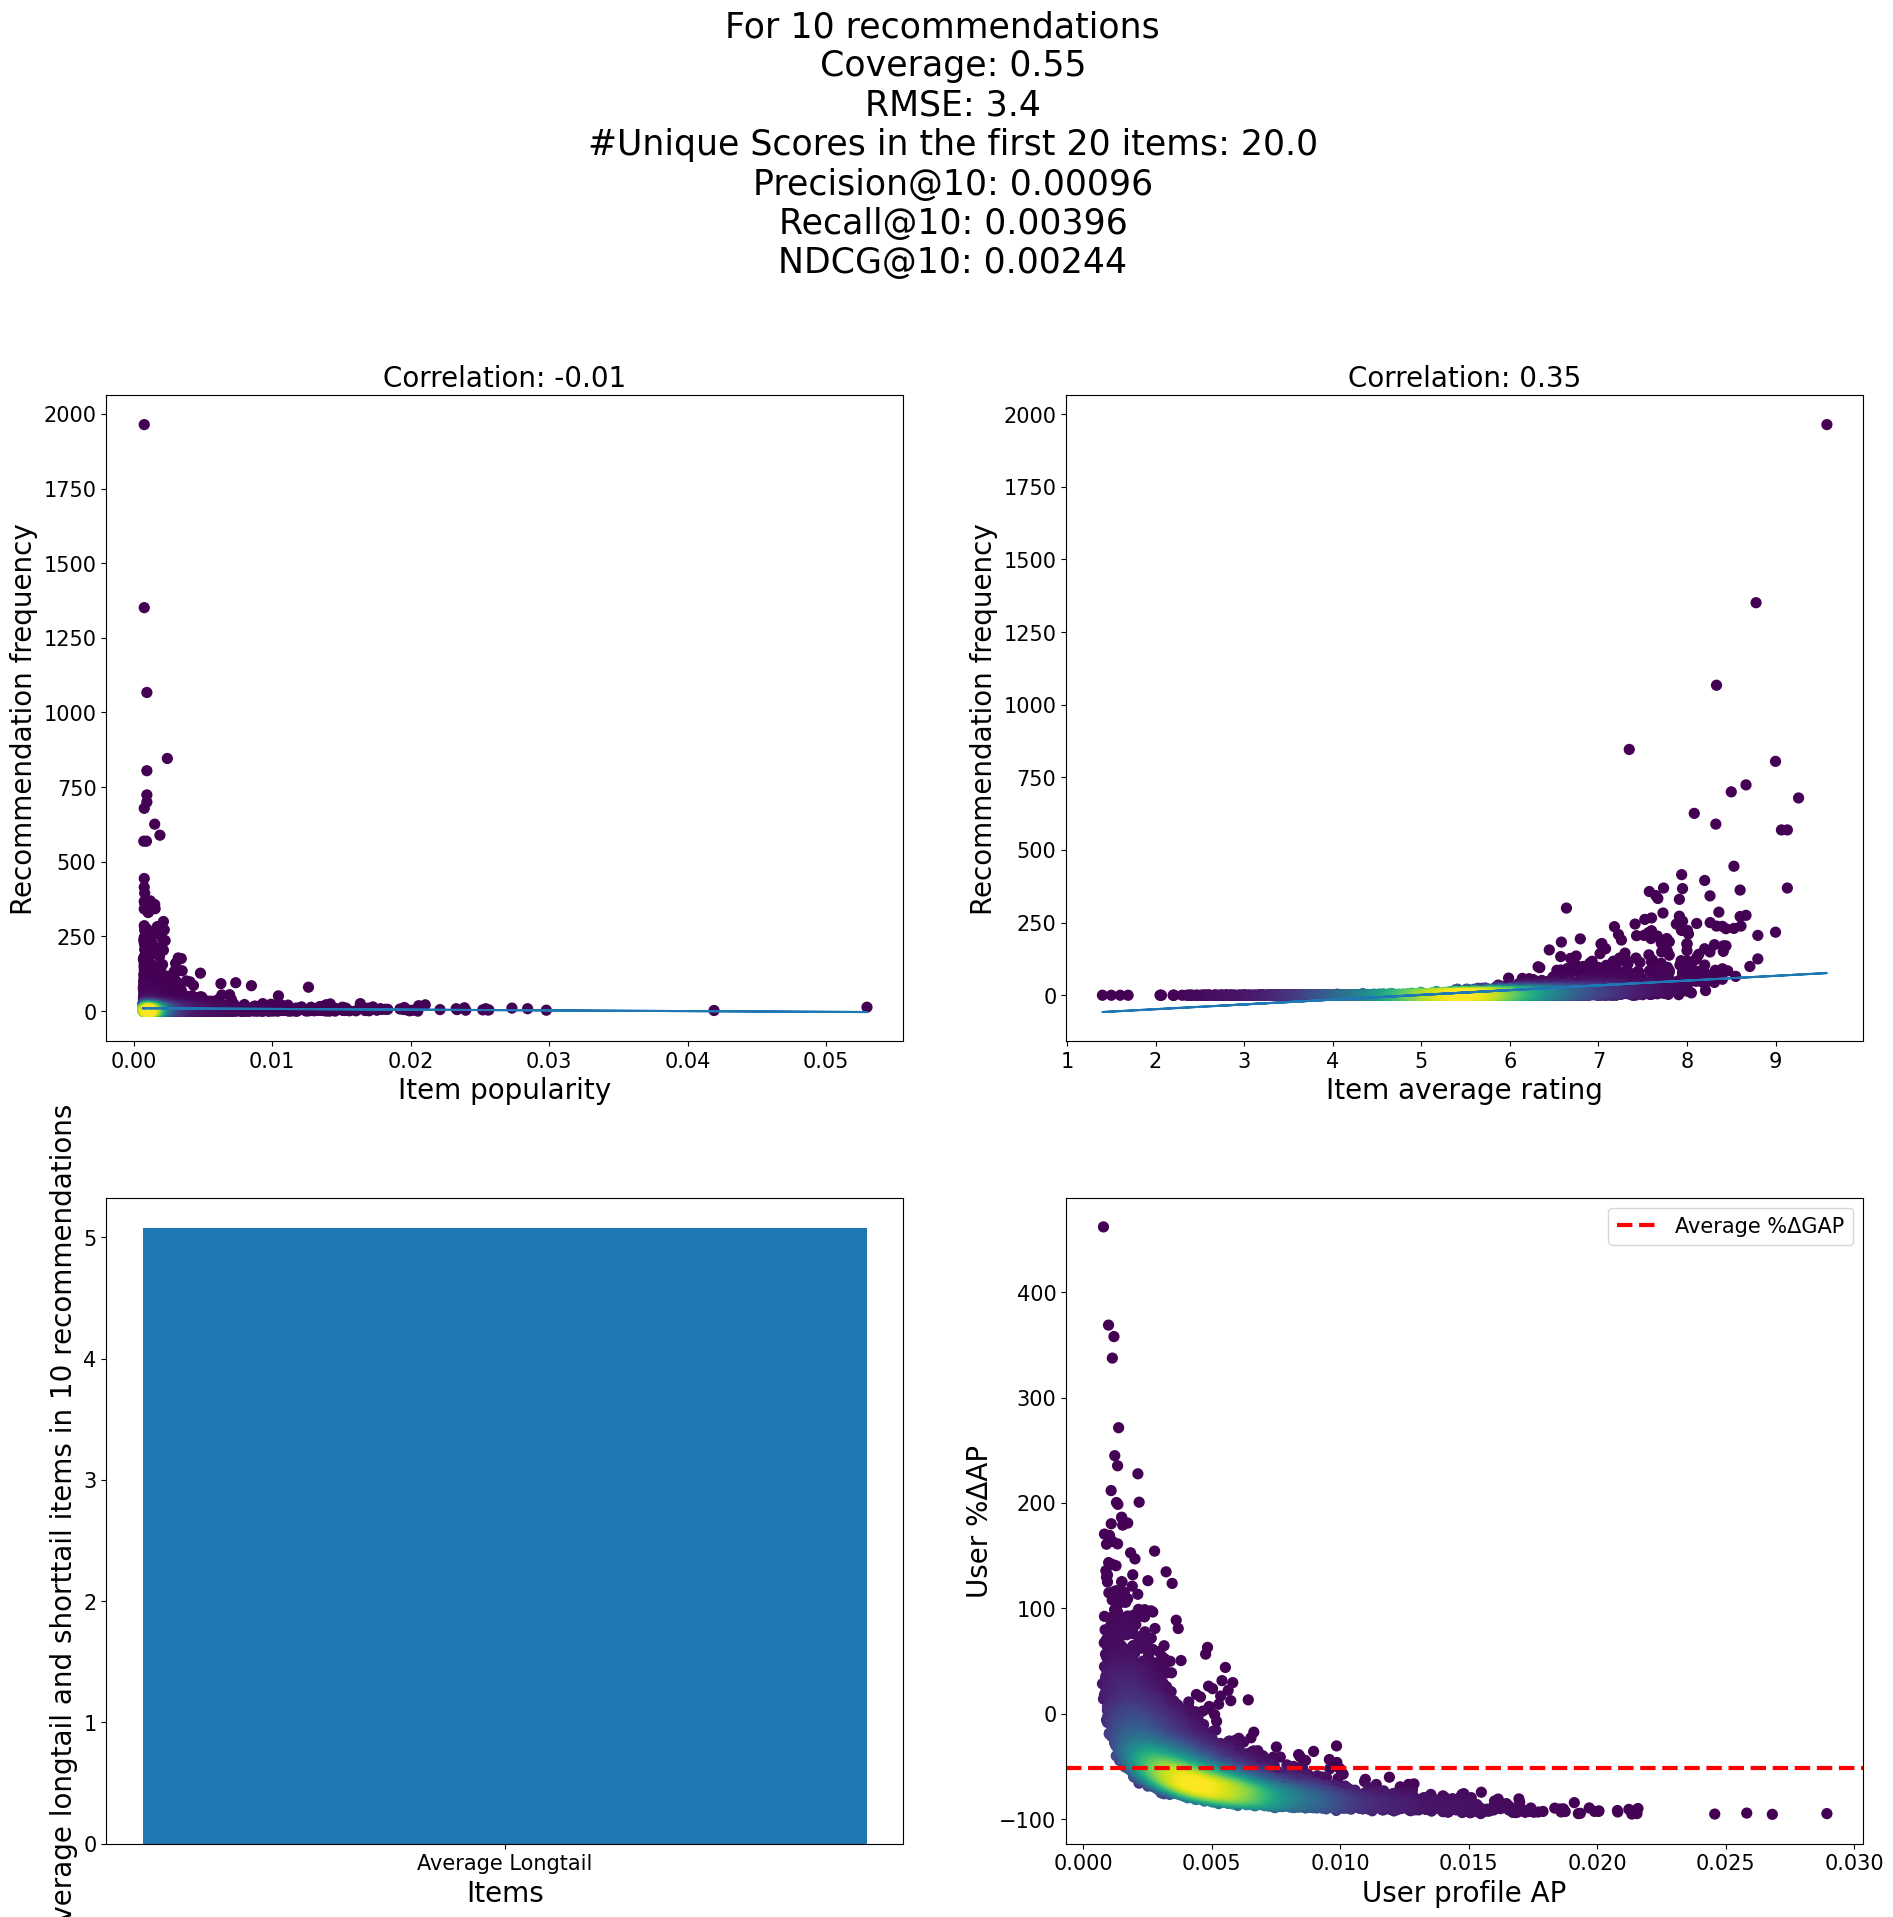

popularity_good {'bias': True}
We got them already
nr of longtail 0
0.0
nr of longtail 0
0.0
nr of longtail 0
0.0
nr of longtail 0
0.0
nr of longtail 0
0.0


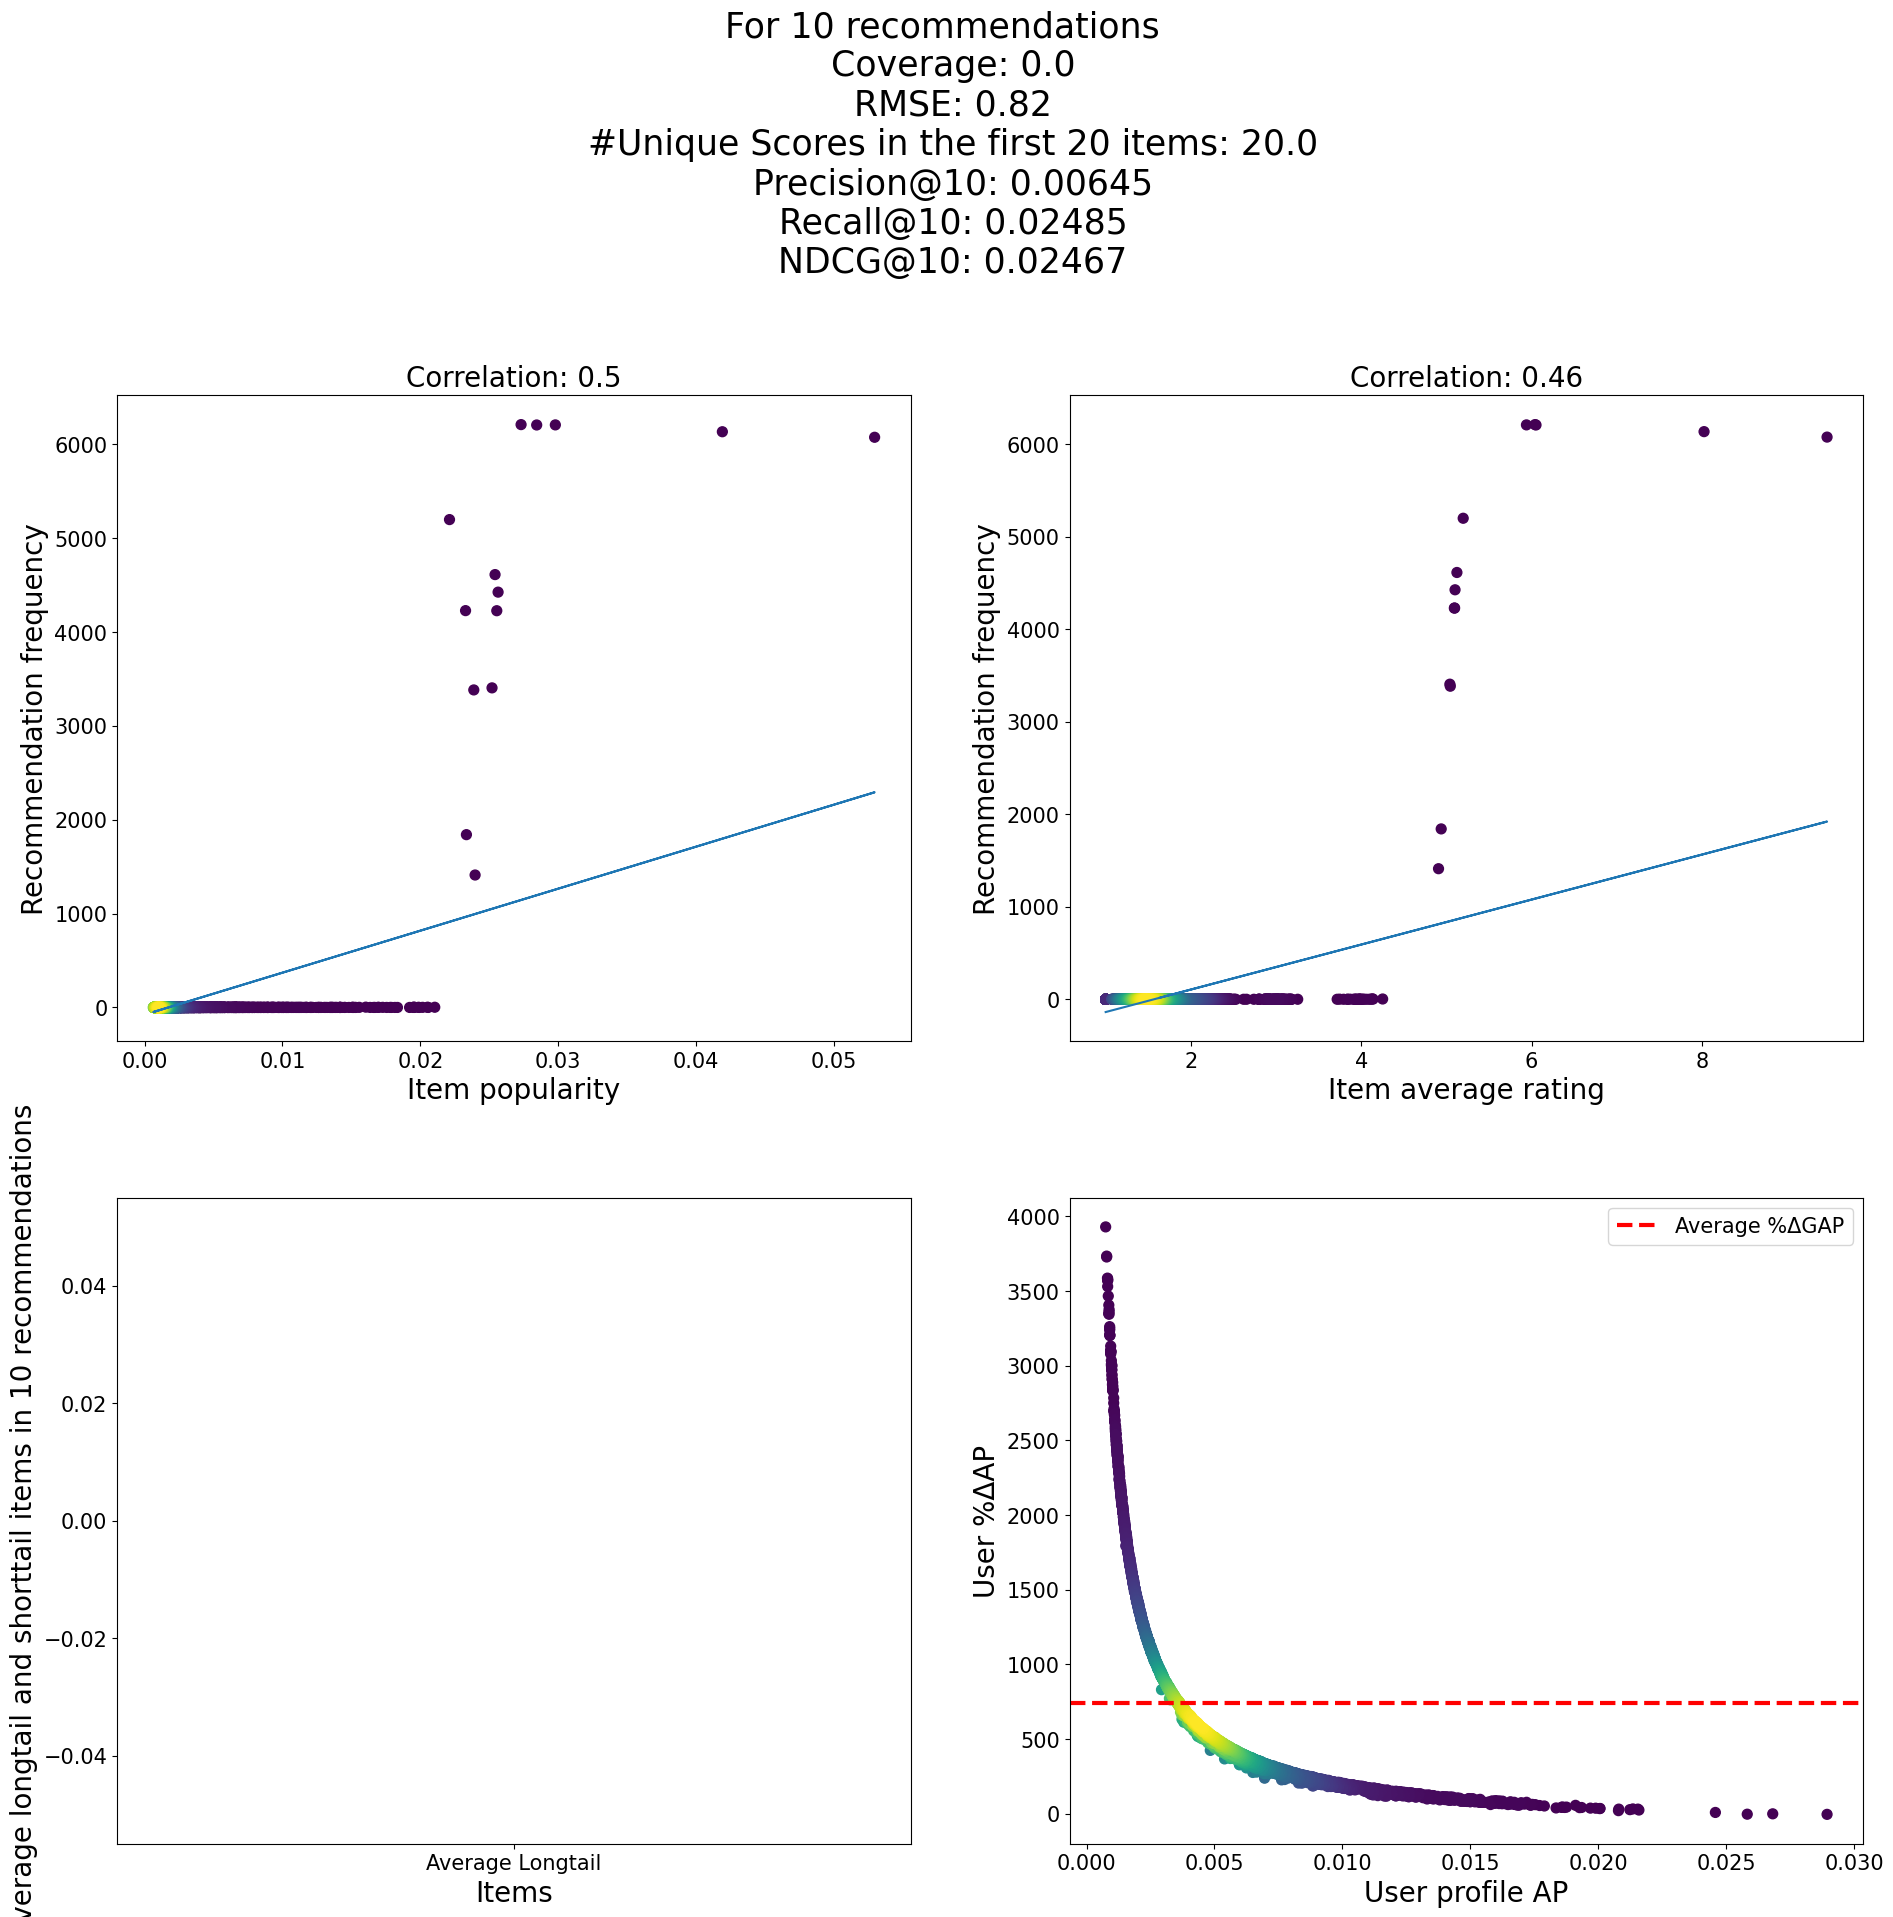

popularity_good {'bias': False}
We got them already
nr of longtail 1
0.0007861635220125787
nr of longtail 1
0.0007861635220125787
nr of longtail 0
0.0
nr of longtail 0
0.0
nr of longtail 1
0.0007867820613690008


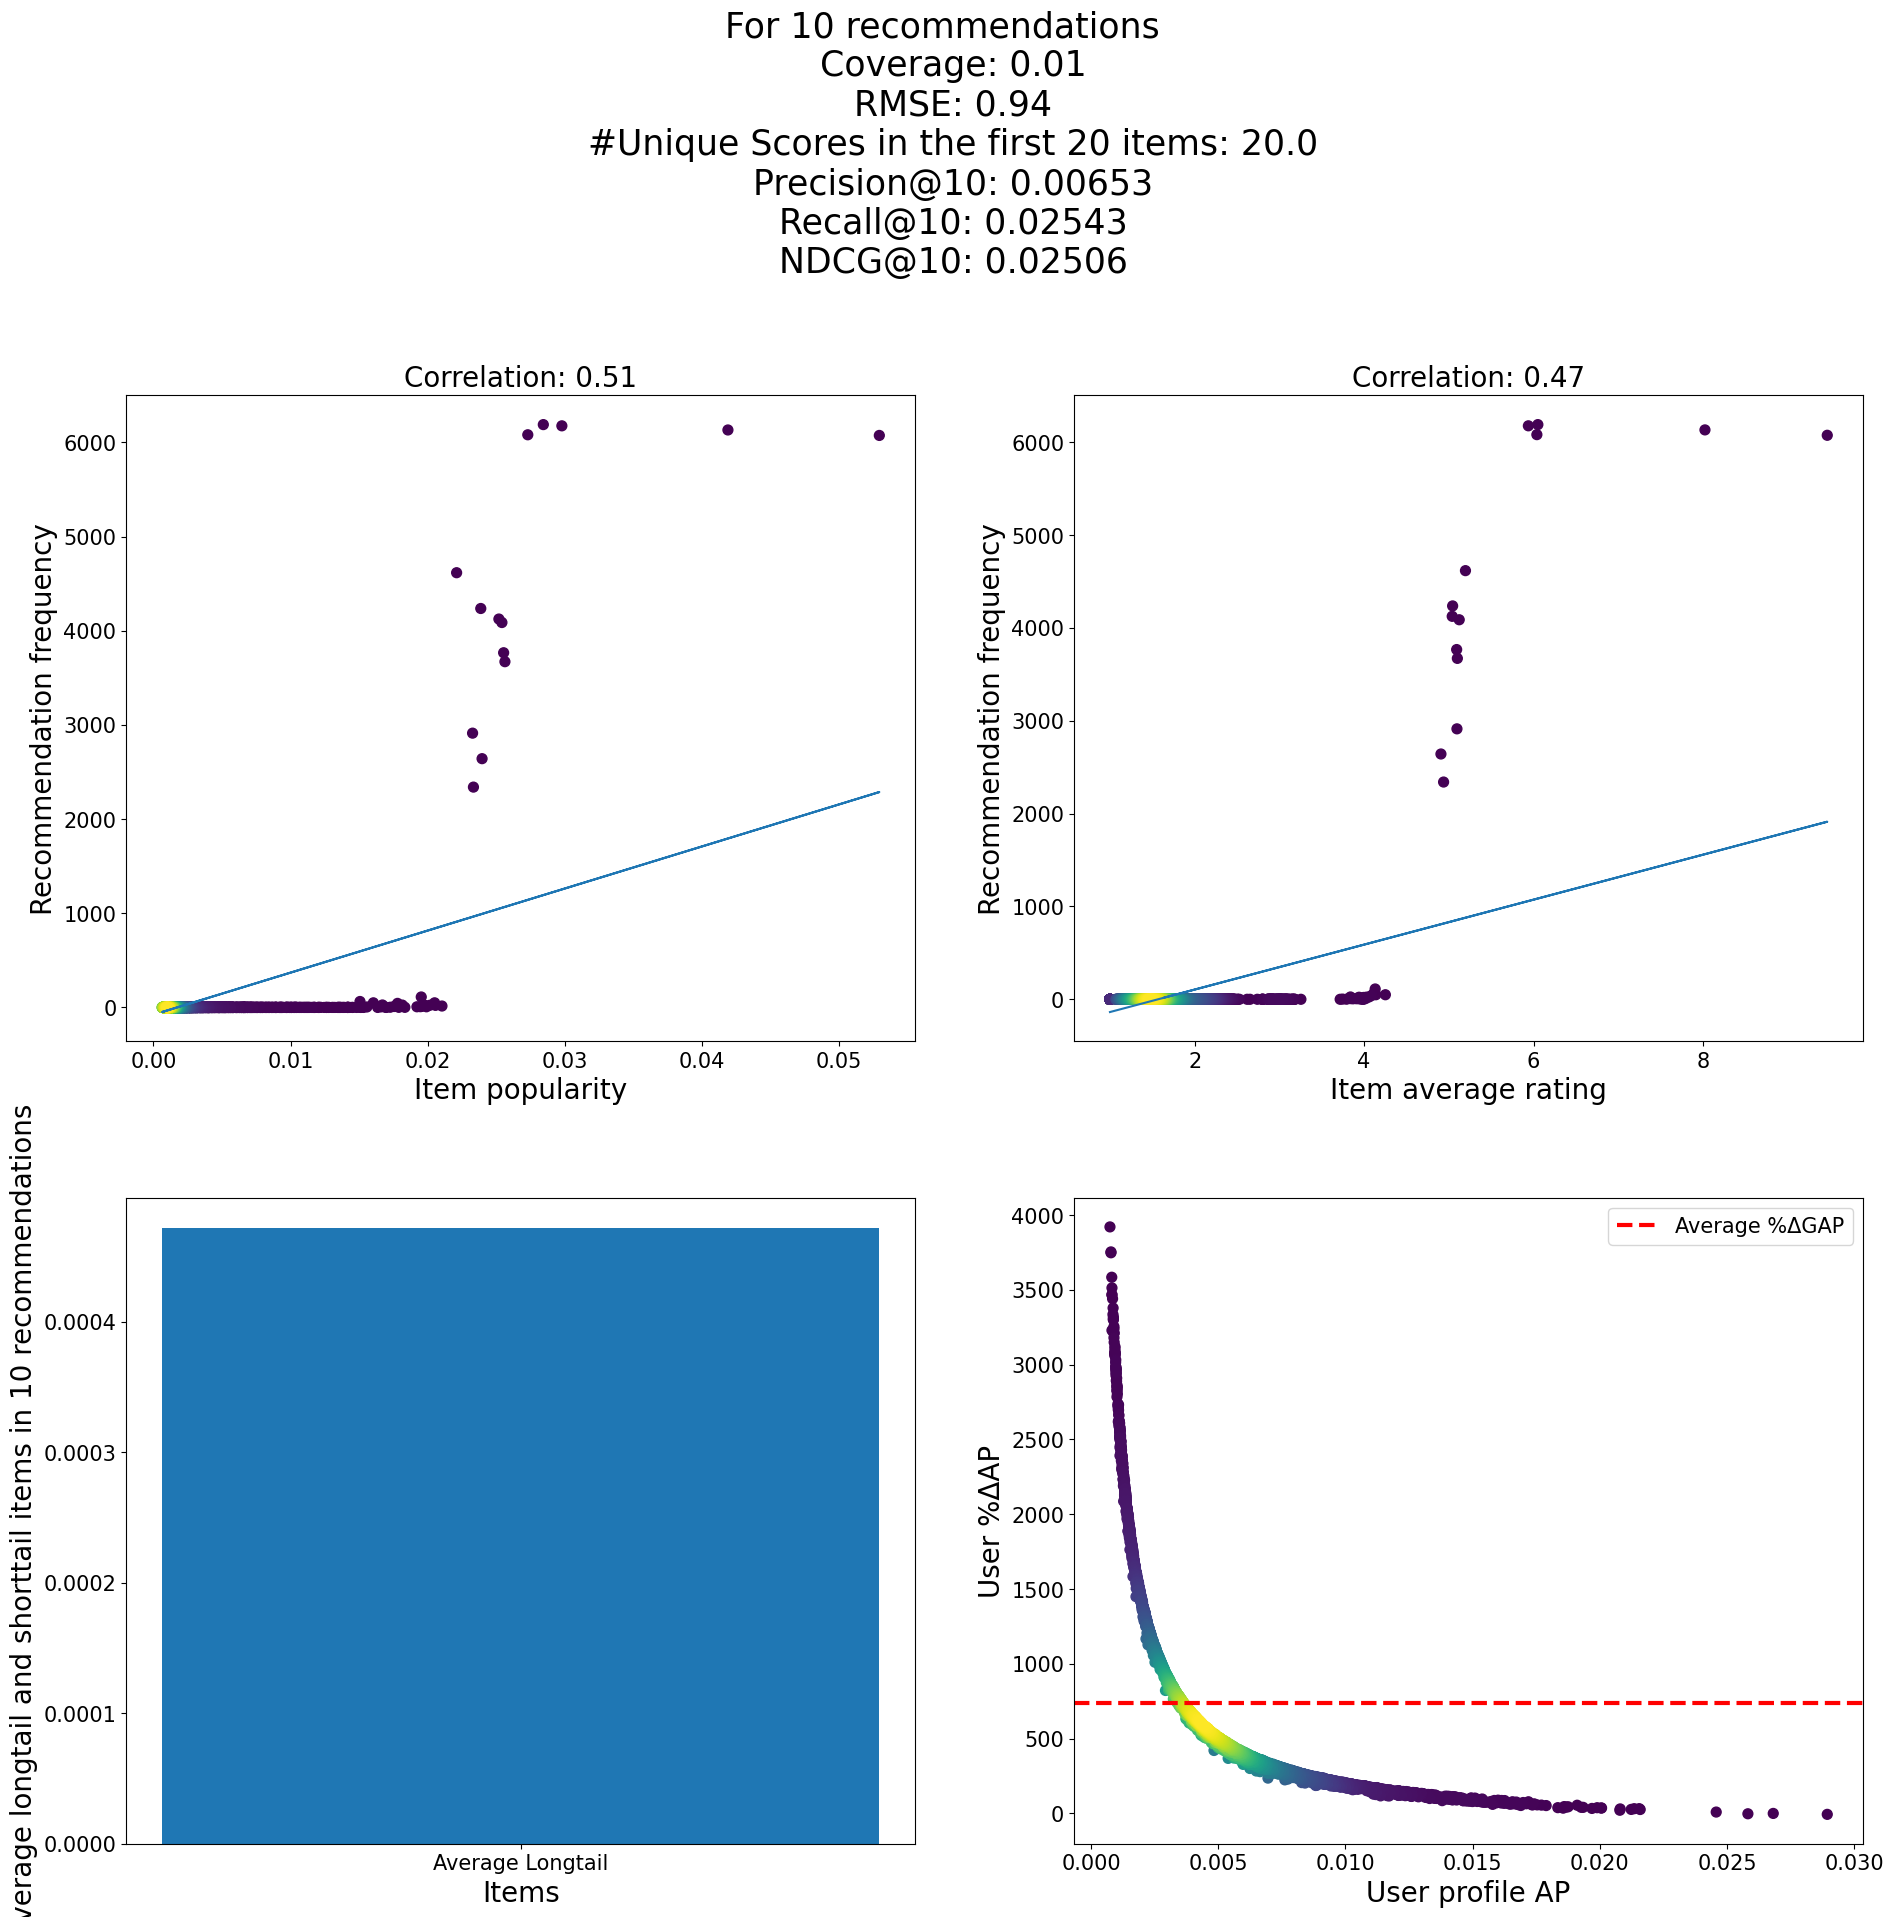

popularity_bad {'bias': True}
We got them already
nr of longtail 740
0.5817610062893082
nr of longtail 755
0.5935534591194969
nr of longtail 678
0.5330188679245284
nr of longtail 740
0.5822187254130606
nr of longtail 733
0.5767112509834775


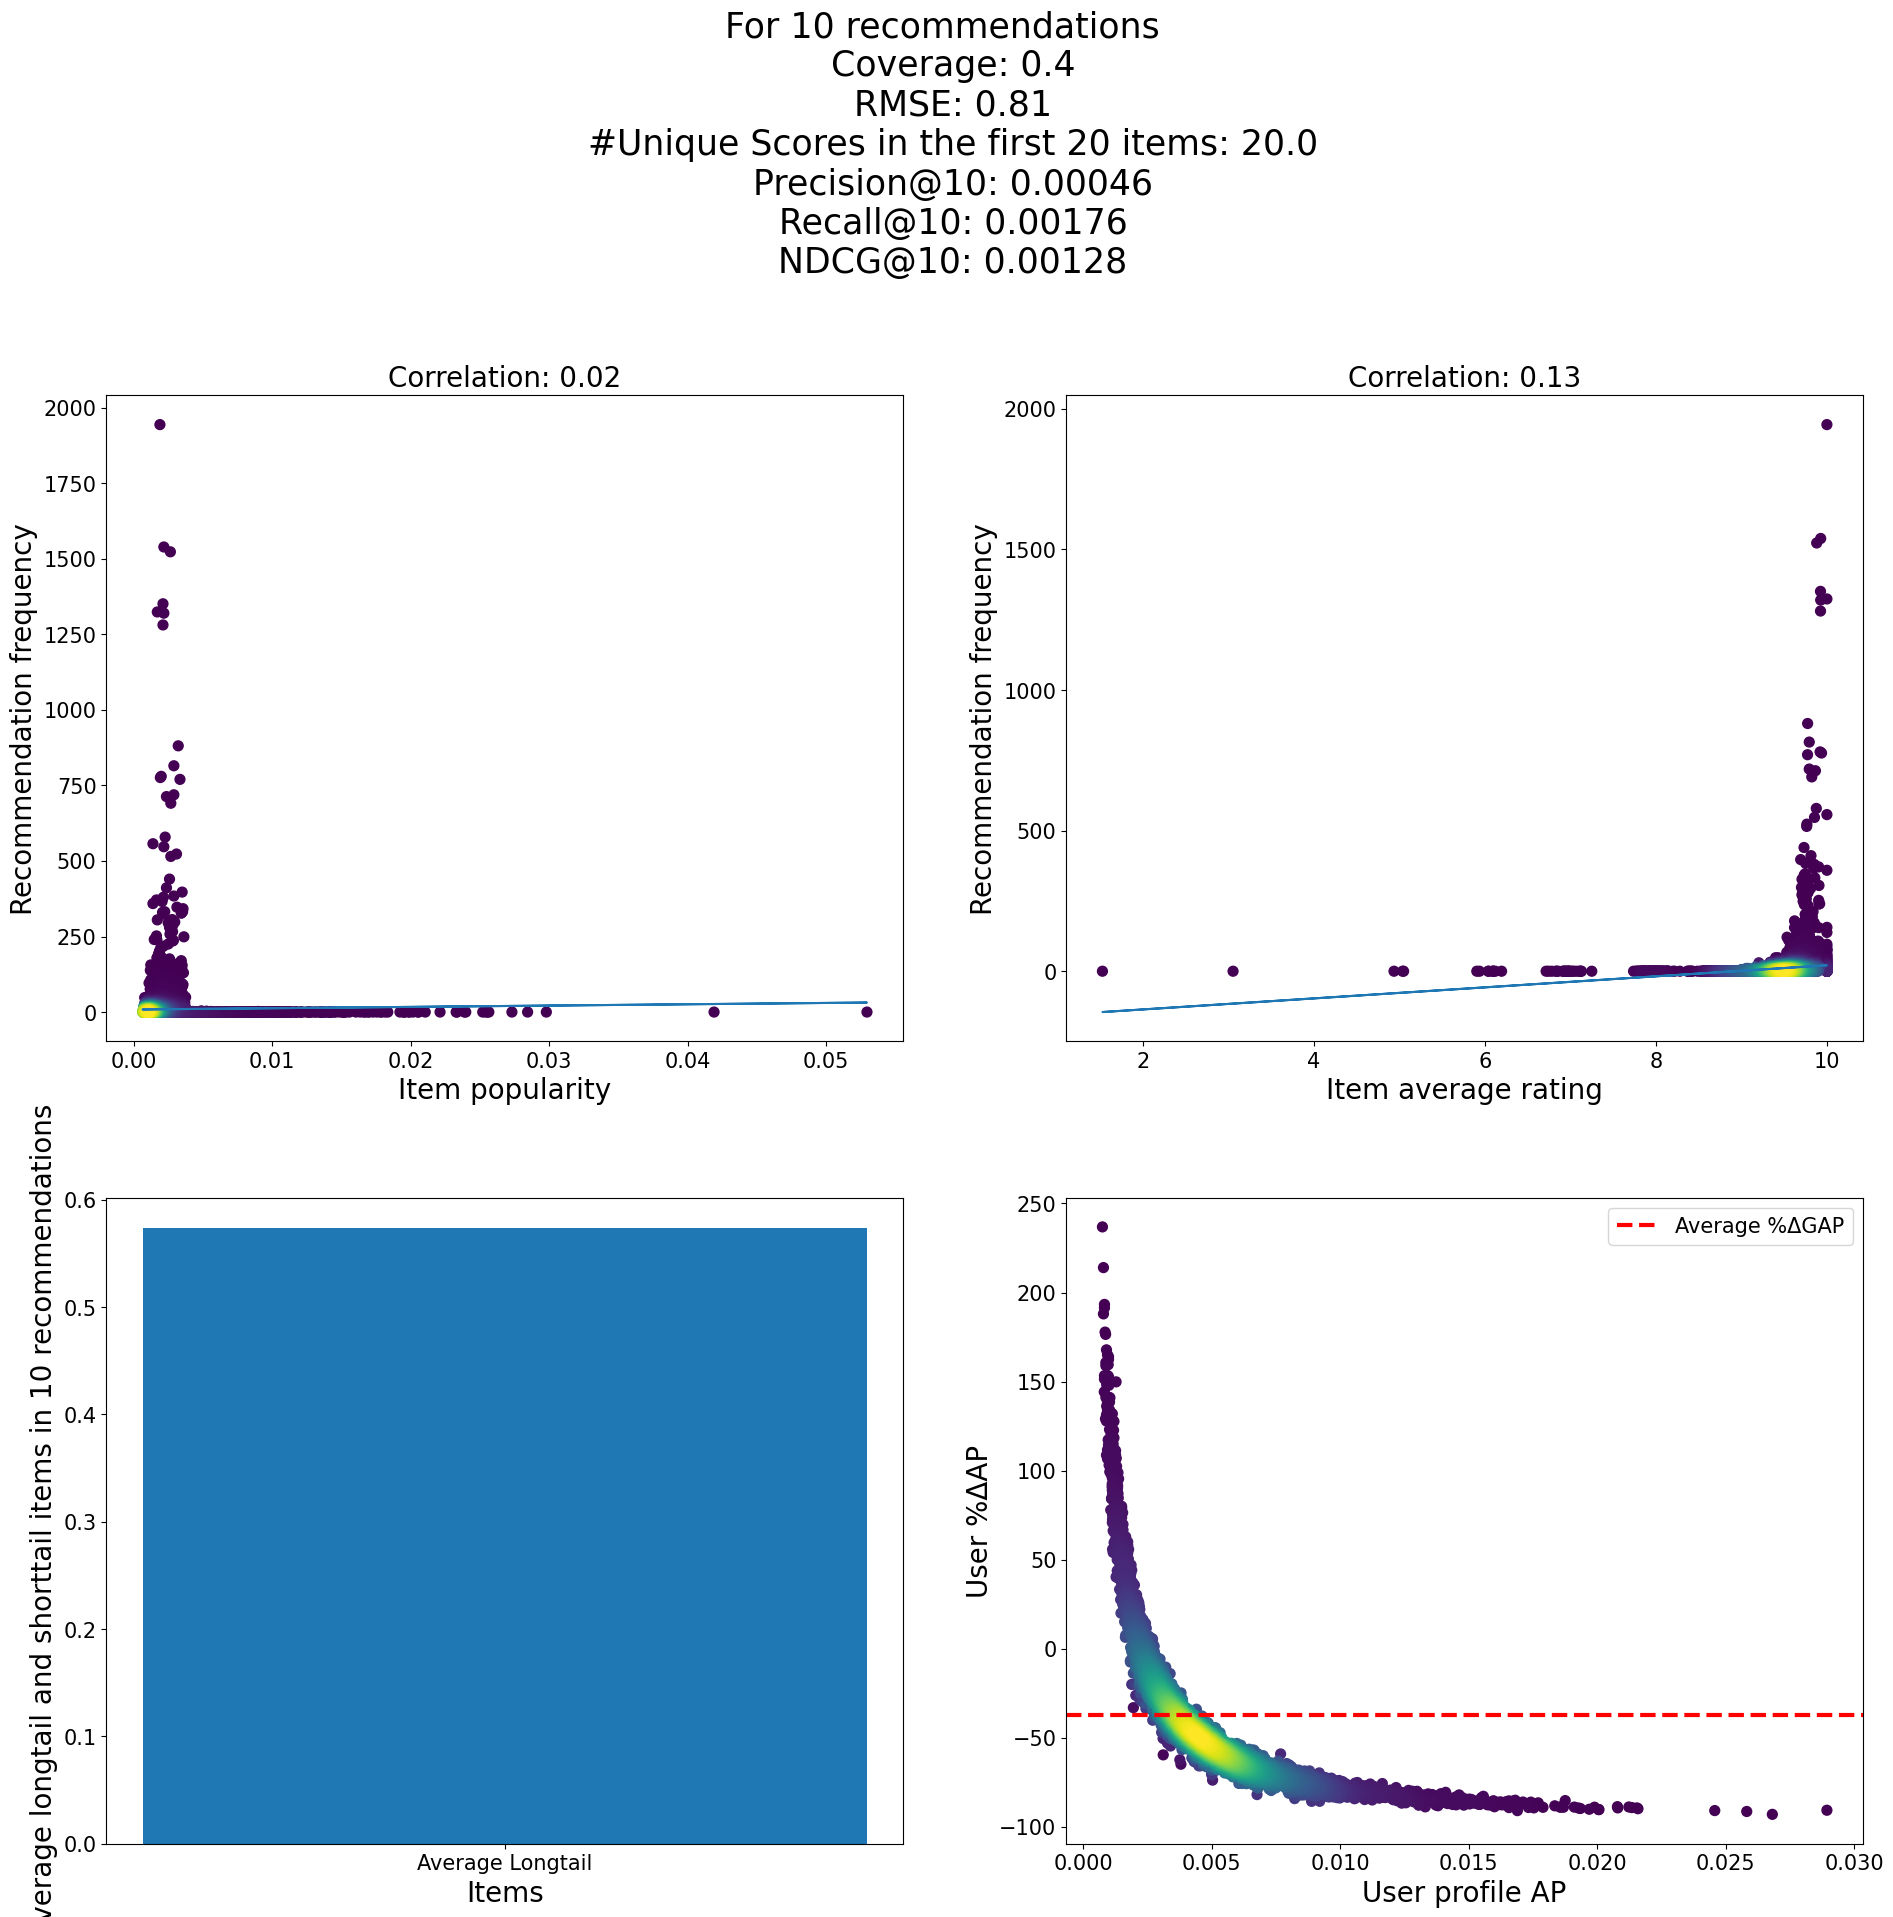

popularity_bad {'bias': False}
We got them already
nr of longtail 10224
8.037735849056604
nr of longtail 10106
7.94496855345912
nr of longtail 9738
7.65566037735849
nr of longtail 9333
7.343036978756884
nr of longtail 10034
7.894571203776554


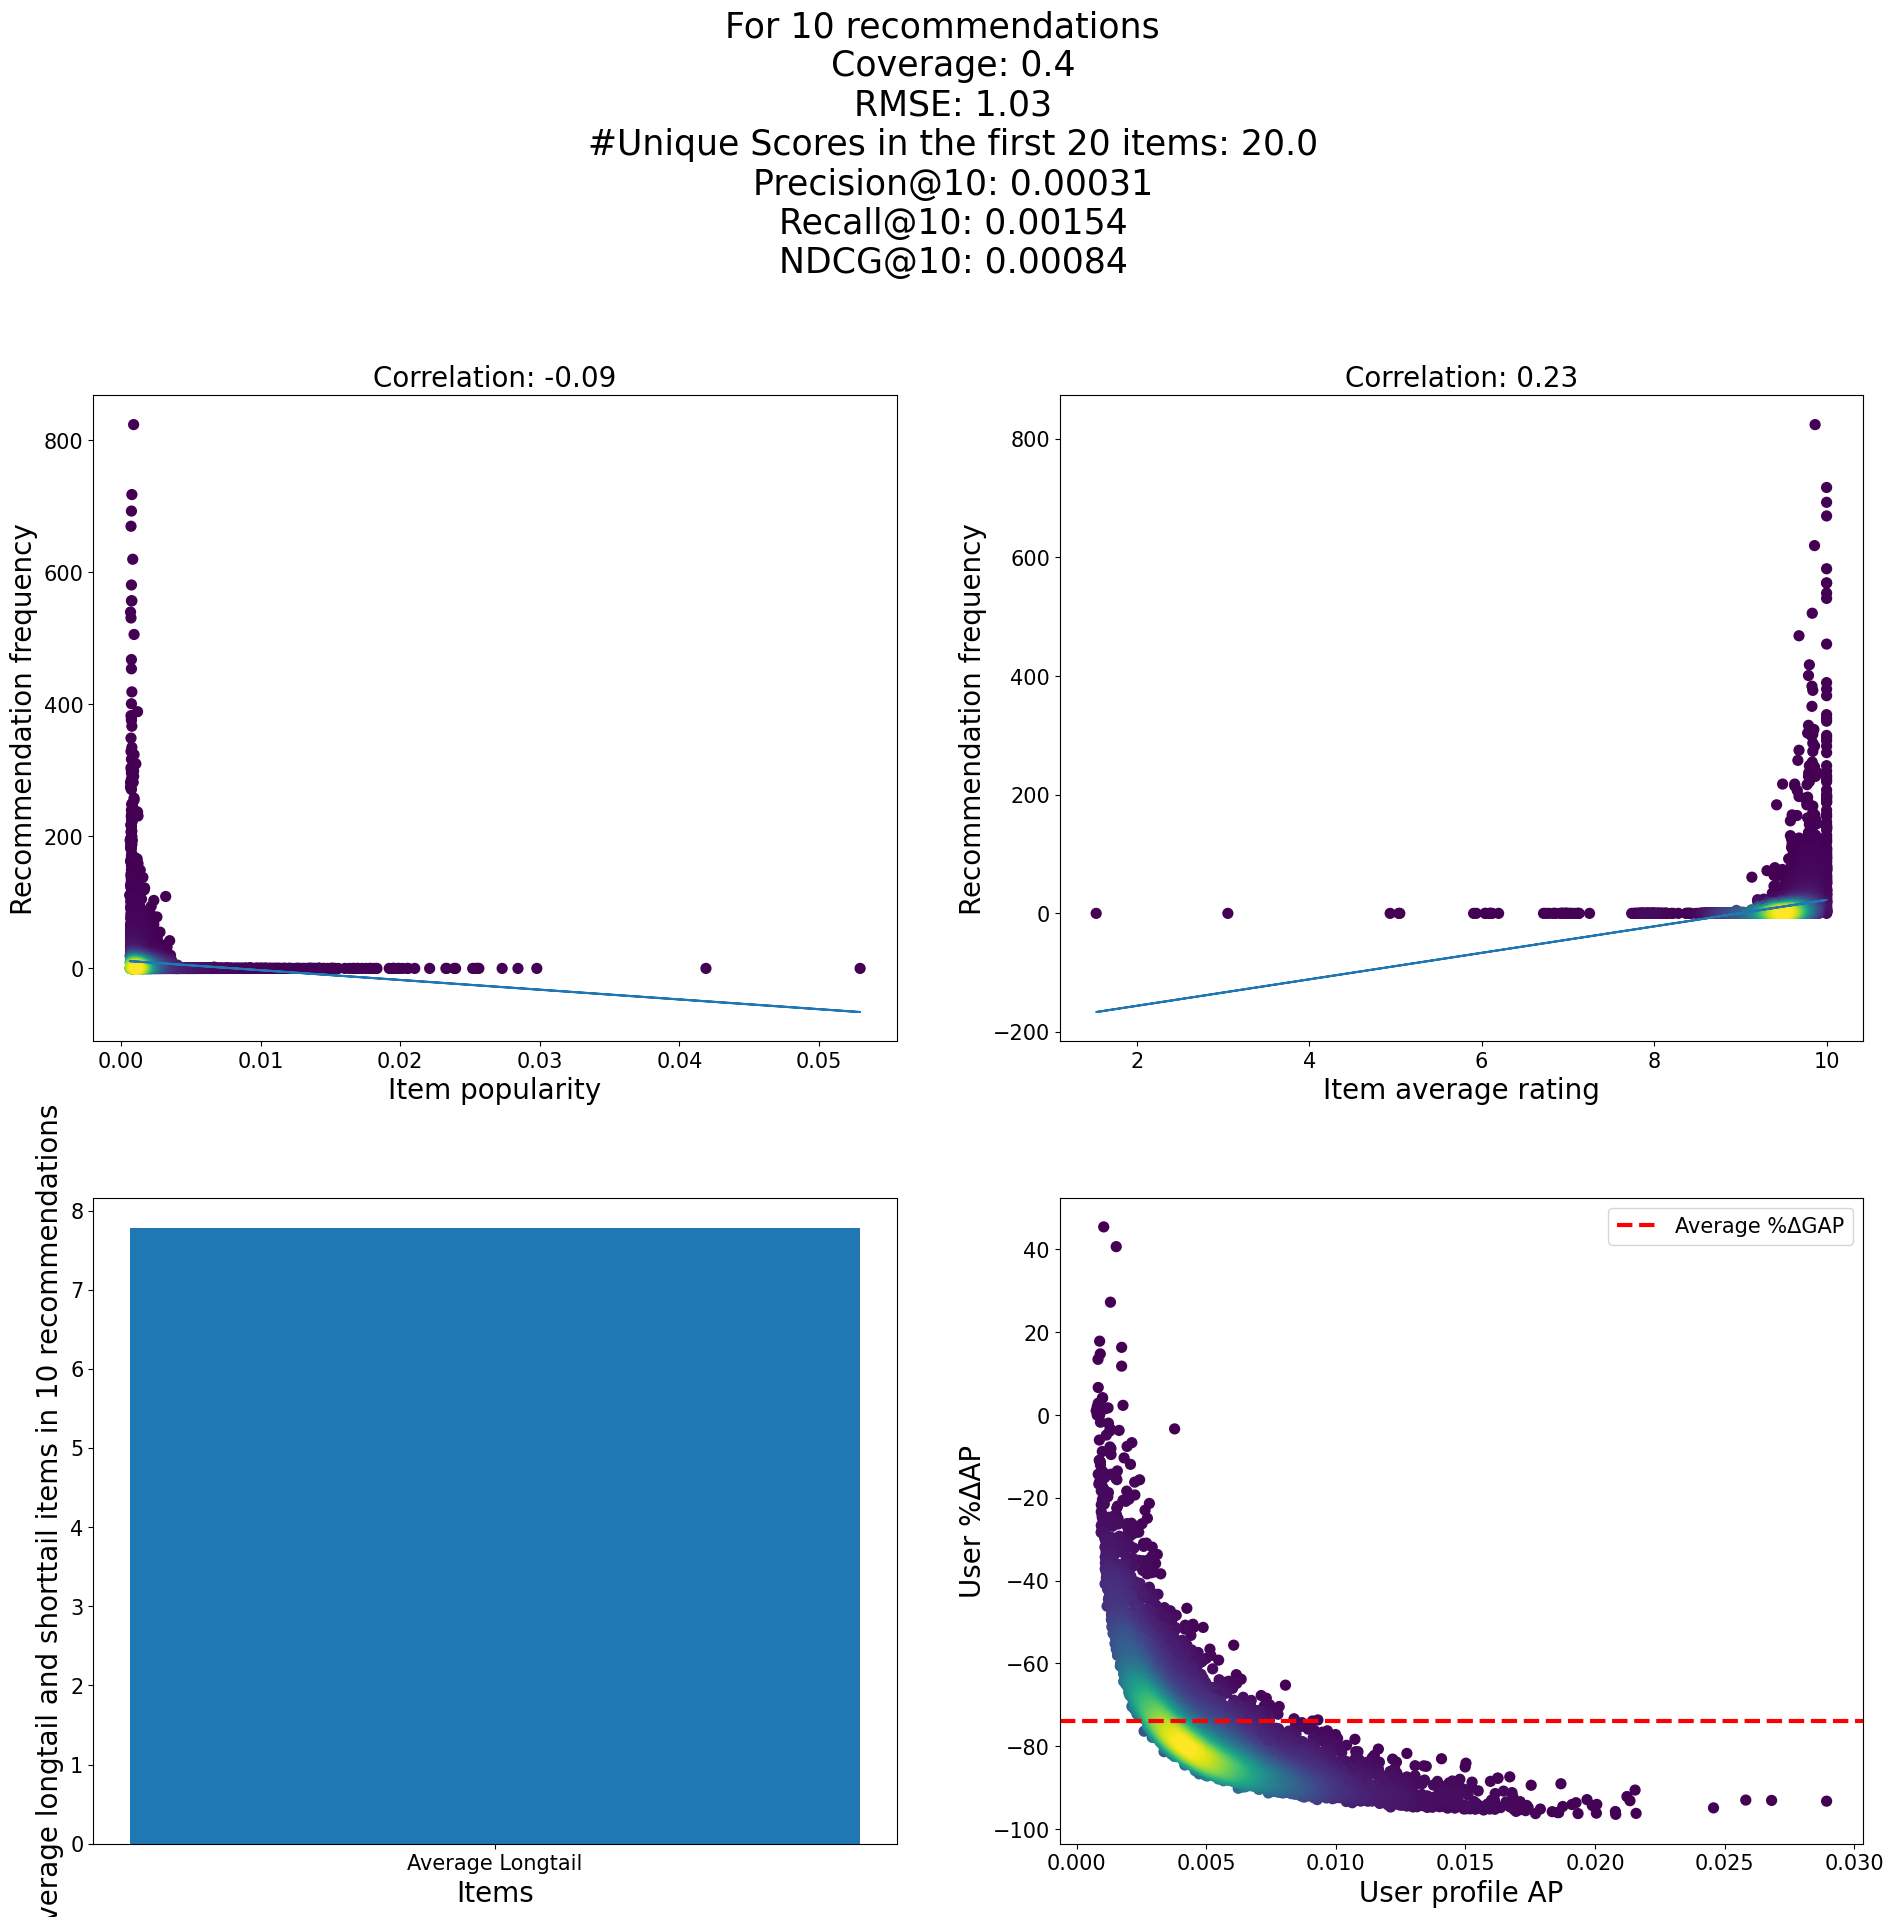

popularity_good_for_bp_ur {'bias': True}
We got them already
nr of longtail 5737
4.510220125786163
nr of longtail 6159
4.841981132075472
nr of longtail 6151
4.835691823899371
nr of longtail 6622
5.210070810385523
nr of longtail 6113
4.809598741148702


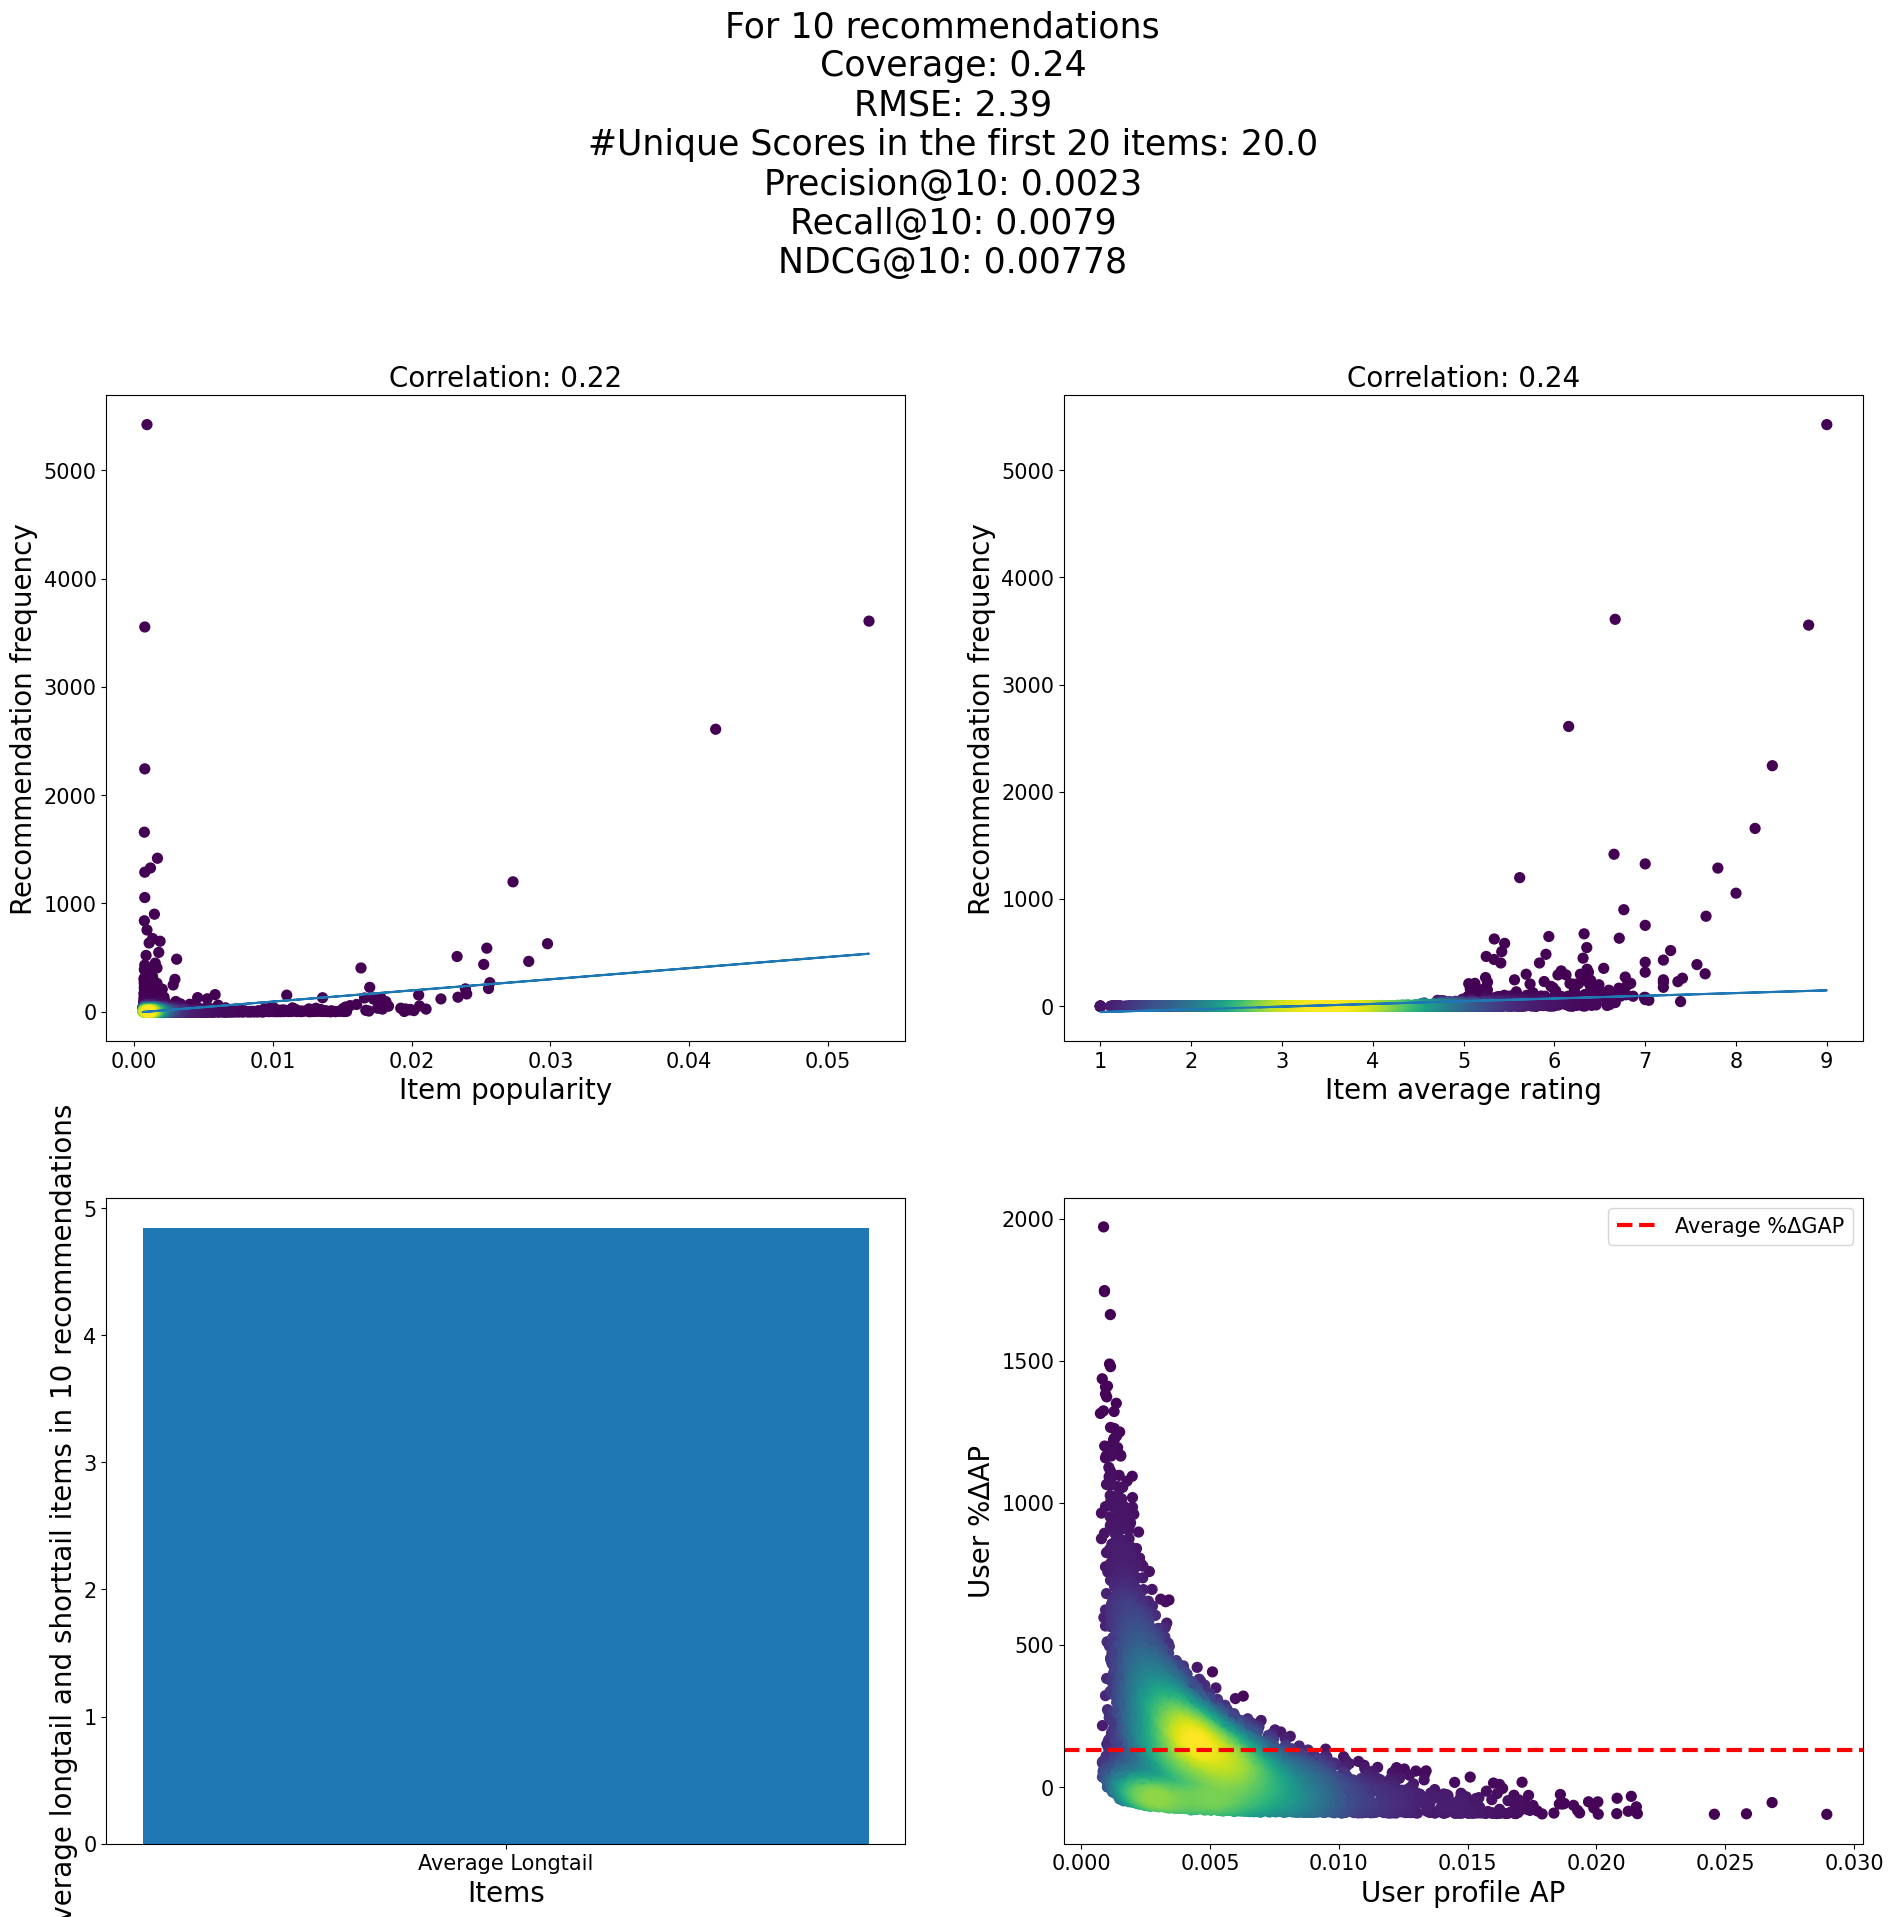

popularity_good_for_bp_ur {'bias': False}
We got them already
nr of longtail 5472
4.30188679245283
nr of longtail 5358
4.212264150943396
nr of longtail 5654
4.44496855345912
nr of longtail 5472
4.305271439811173
nr of longtail 5361
4.217938630999213


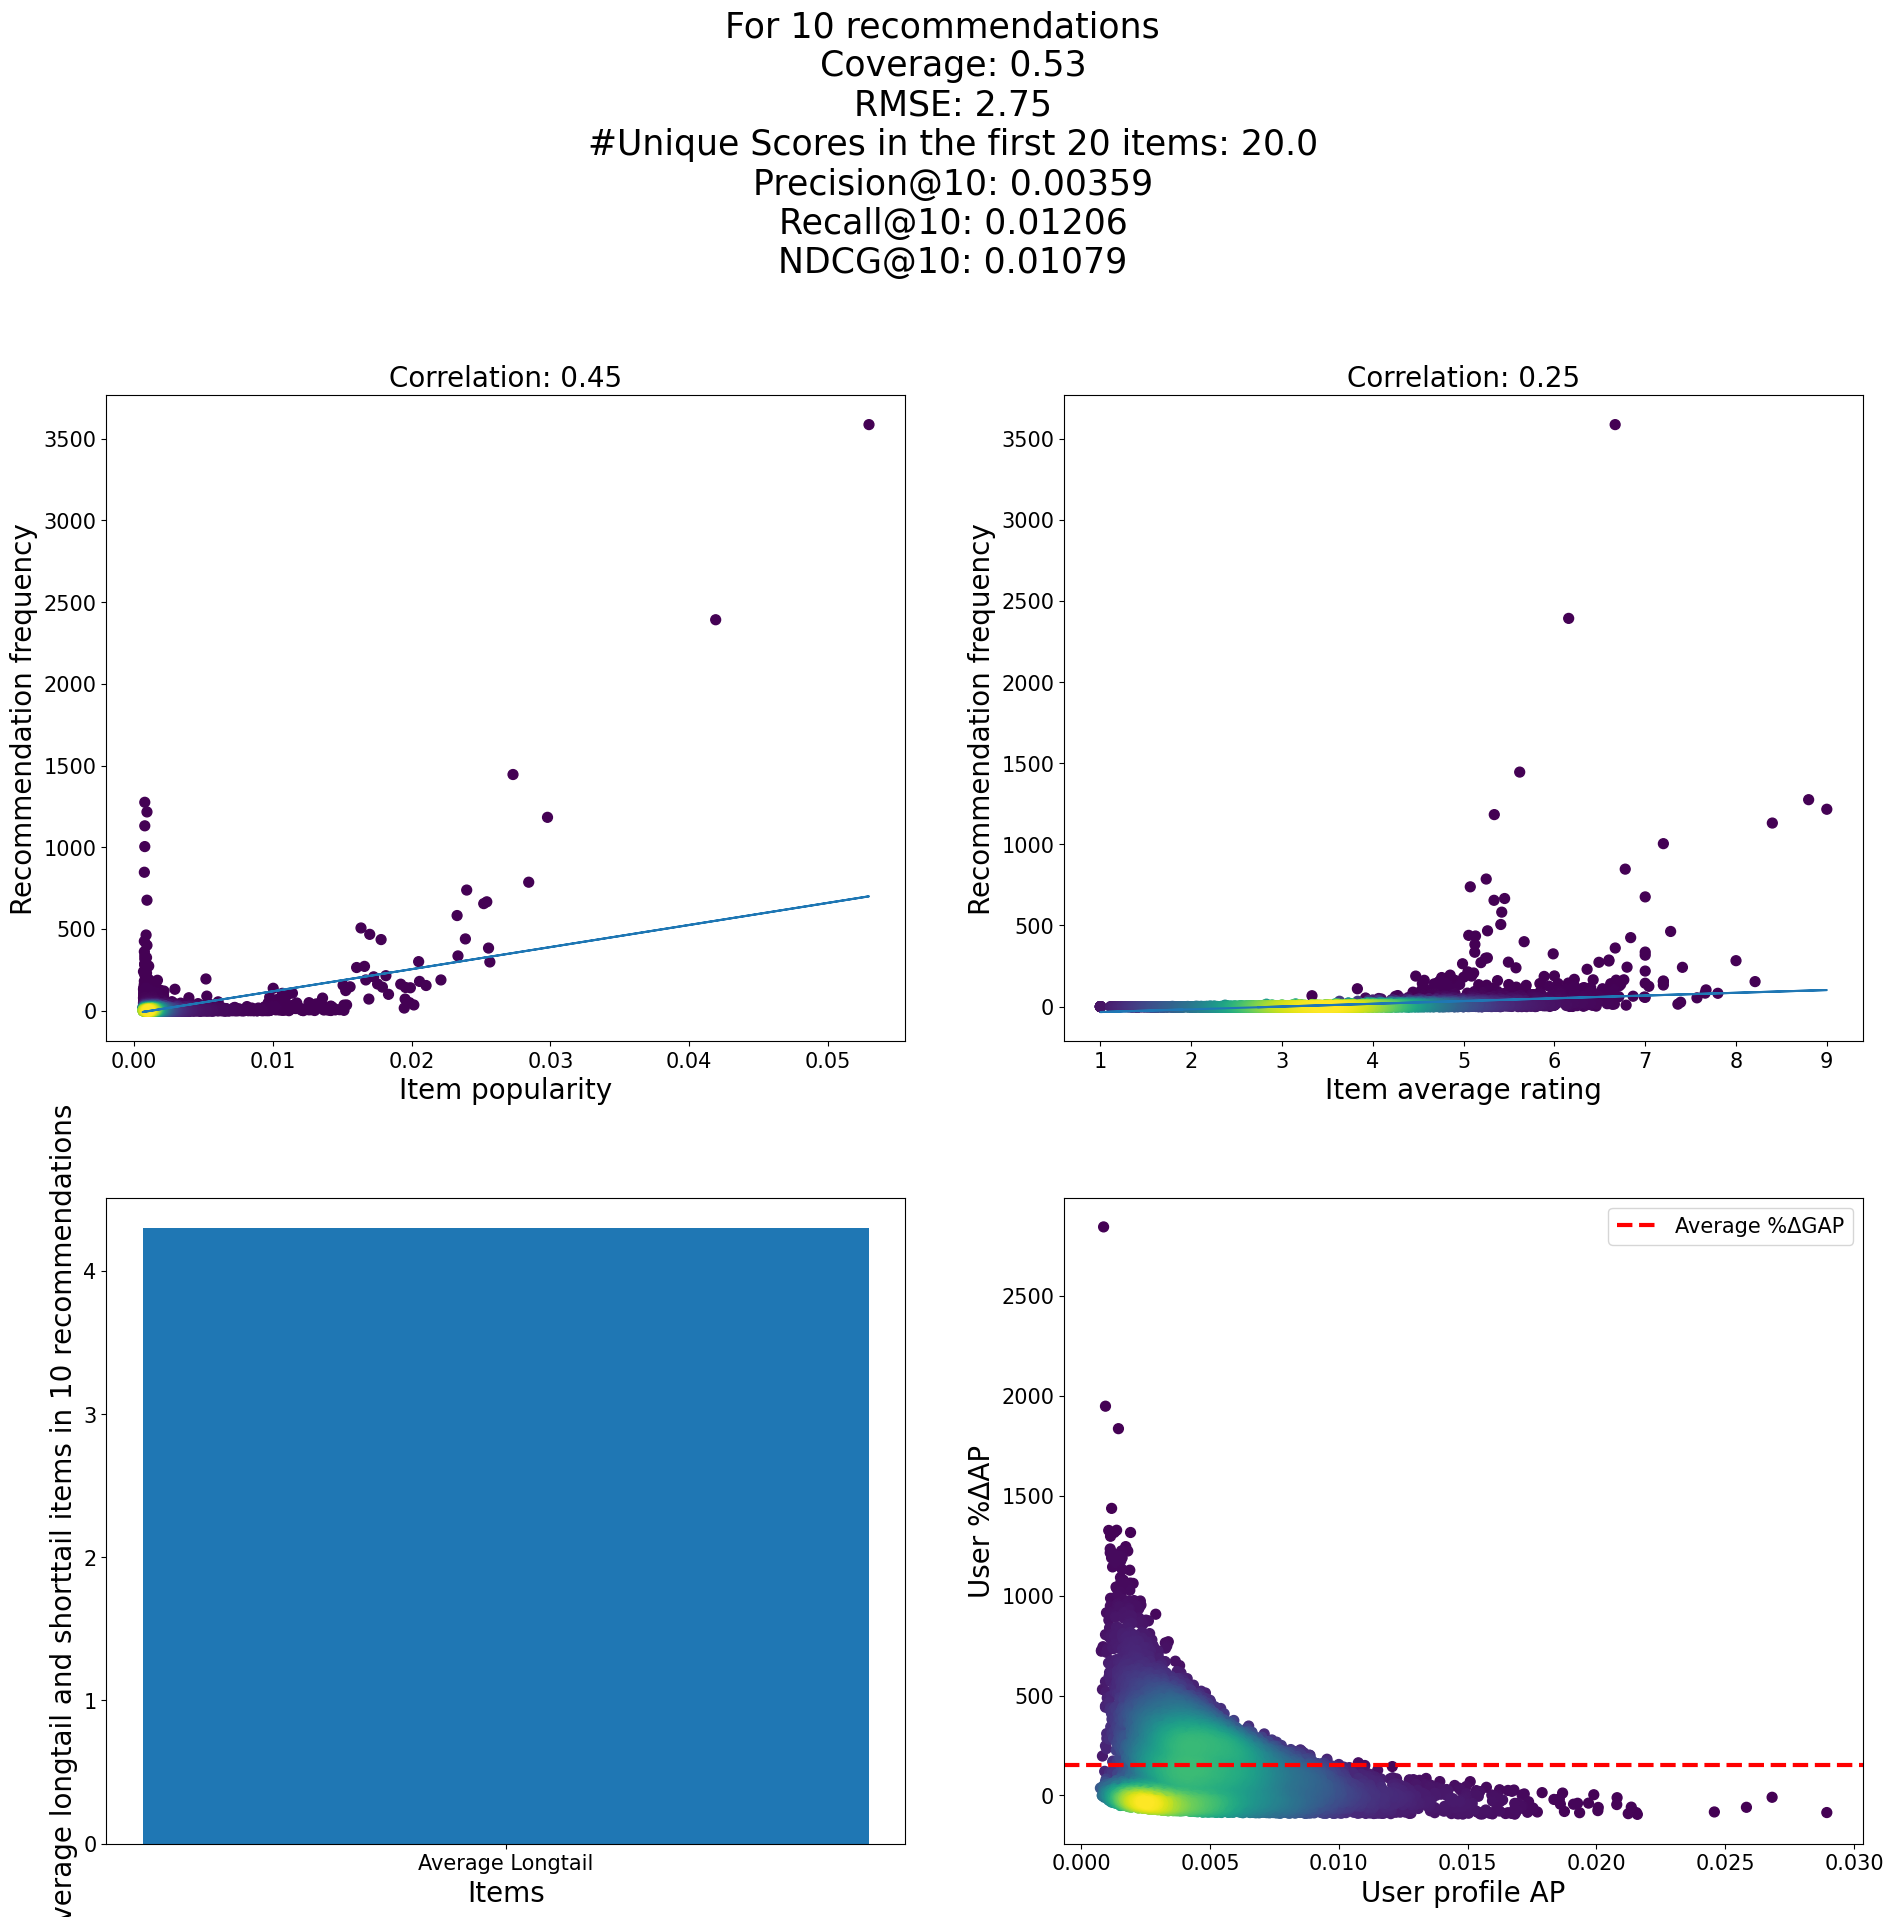

popularity_bad_for_bp_ur {'bias': True}
We got them already
nr of longtail 3574
2.809748427672956
nr of longtail 3848
3.0251572327044025
nr of longtail 3885
3.0542452830188678
nr of longtail 4356
3.4272226593233674
nr of longtail 3912
3.0778914240755313


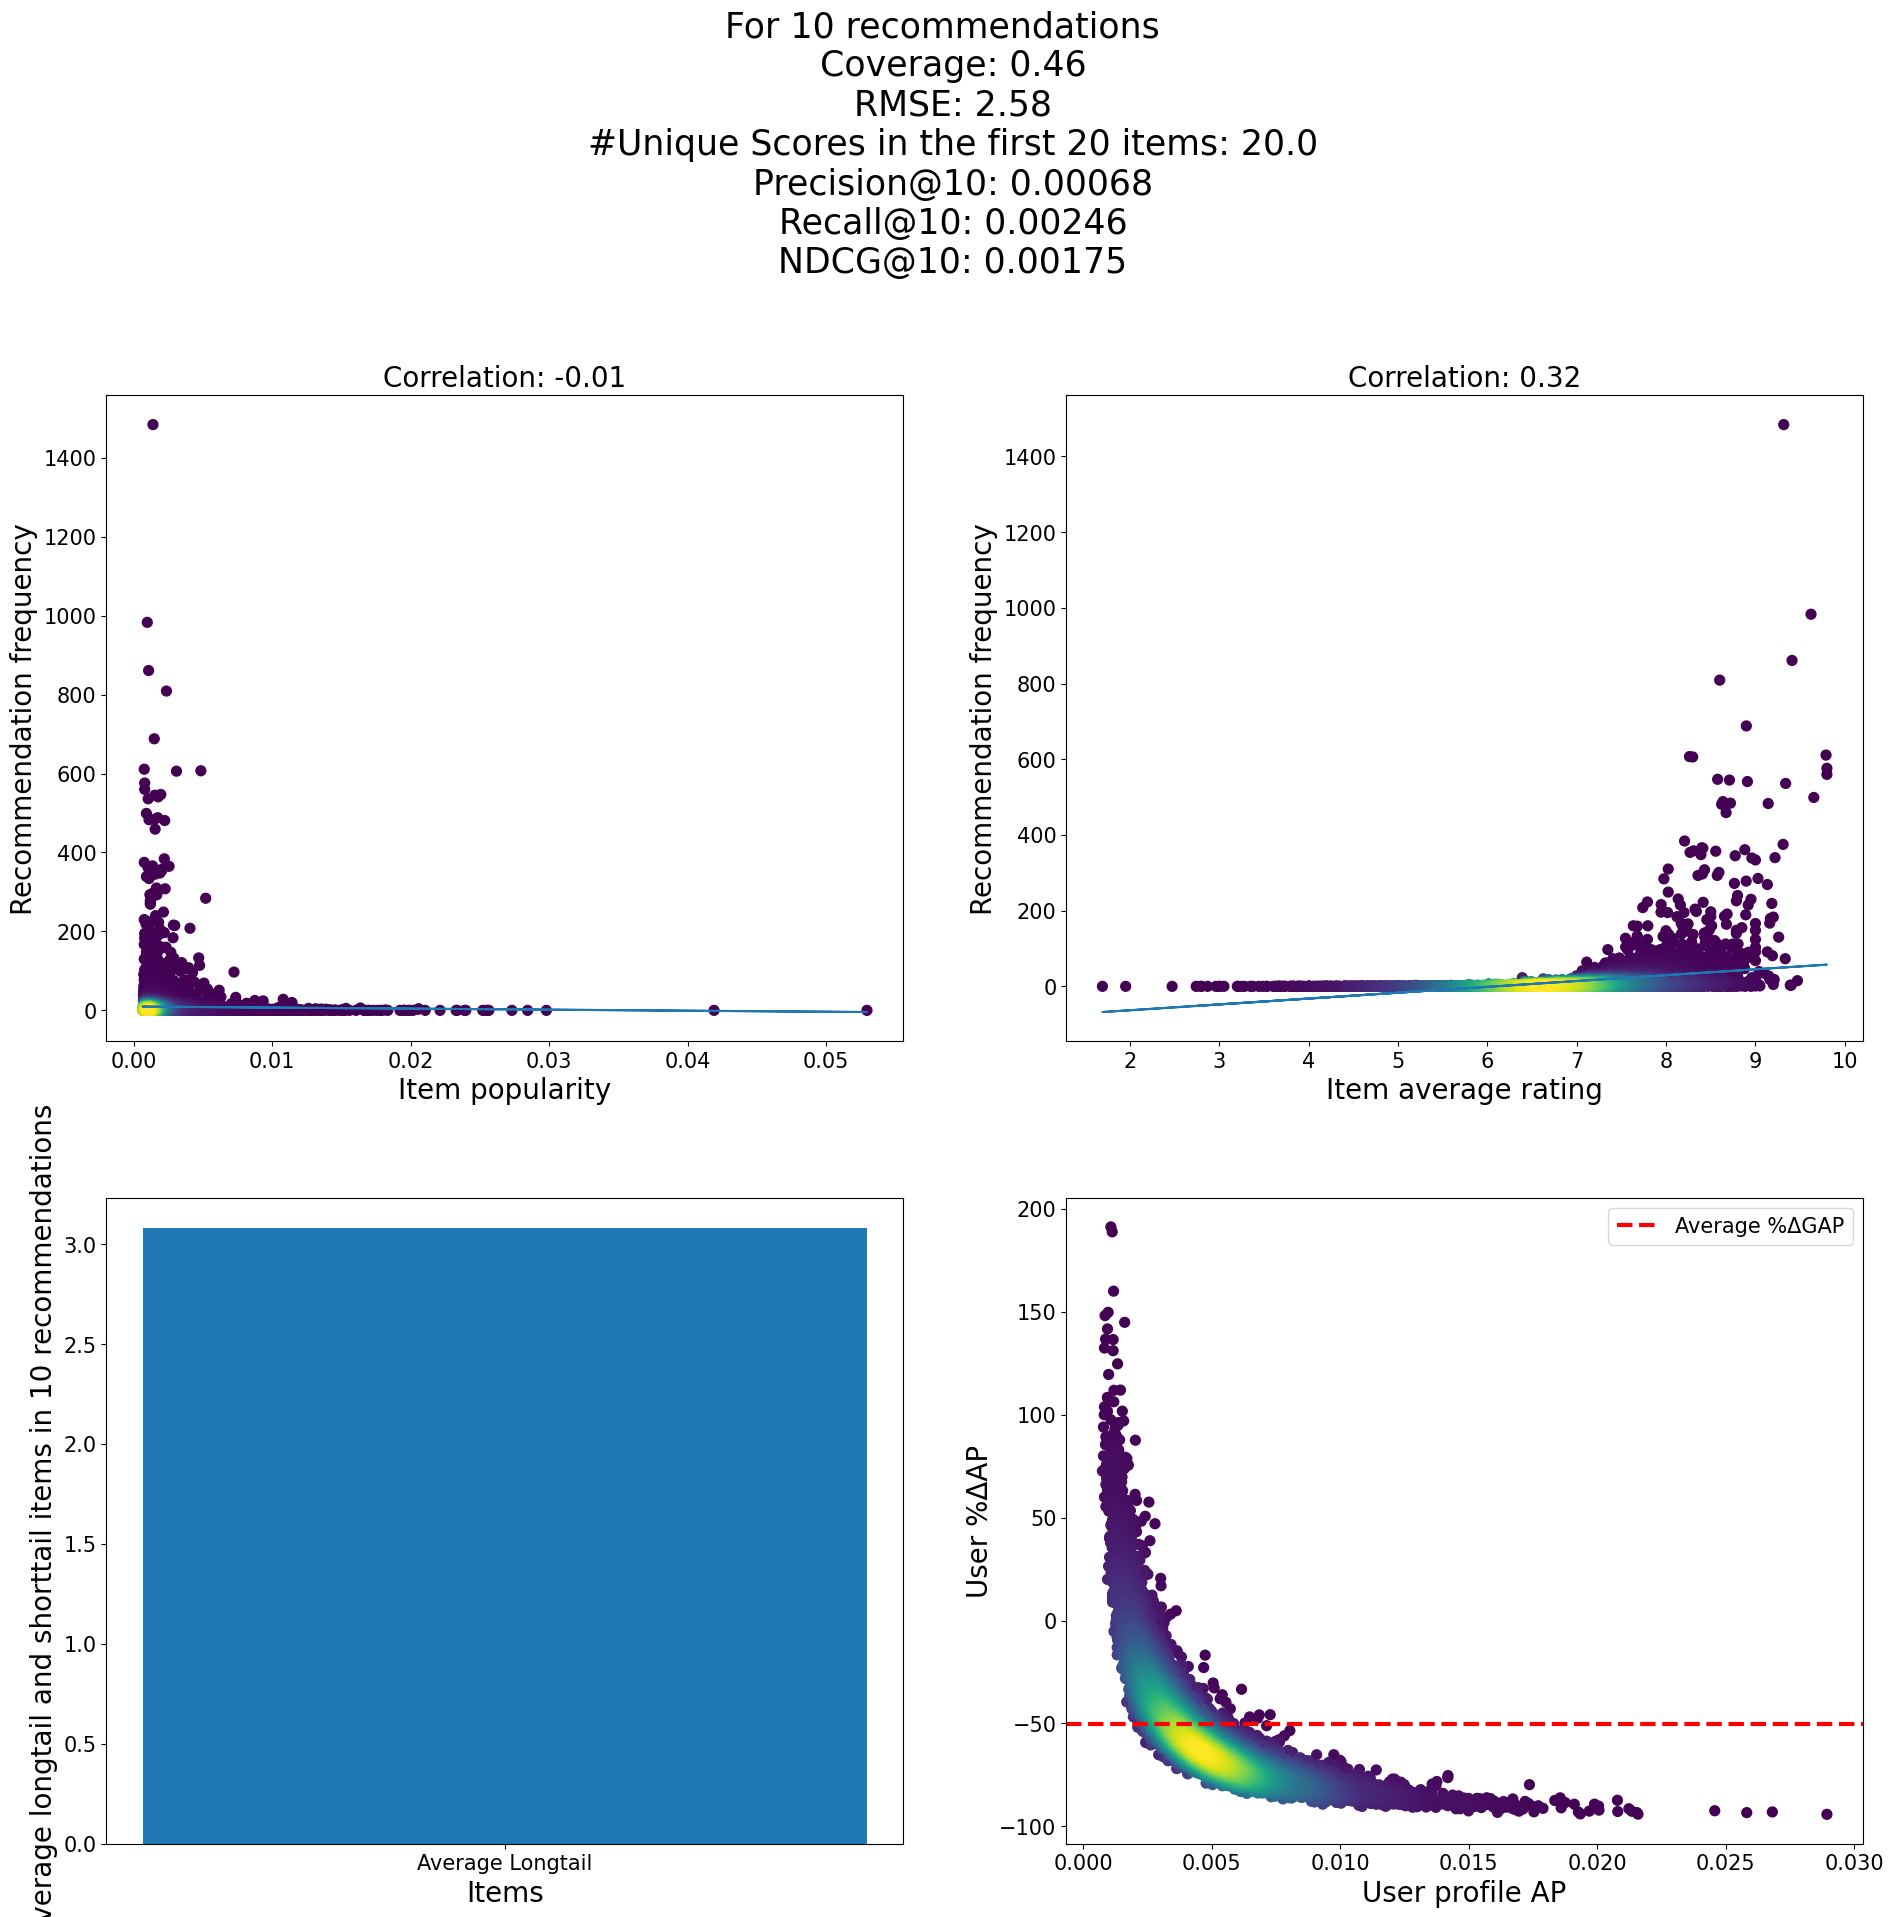

popularity_bad_for_bp_ur {'bias': False}
We got them already
nr of longtail 6652
5.229559748427673
nr of longtail 6898
5.422955974842767
nr of longtail 6955
5.4677672955974845
nr of longtail 6204
4.881195908733281
nr of longtail 6634
5.219512195121951


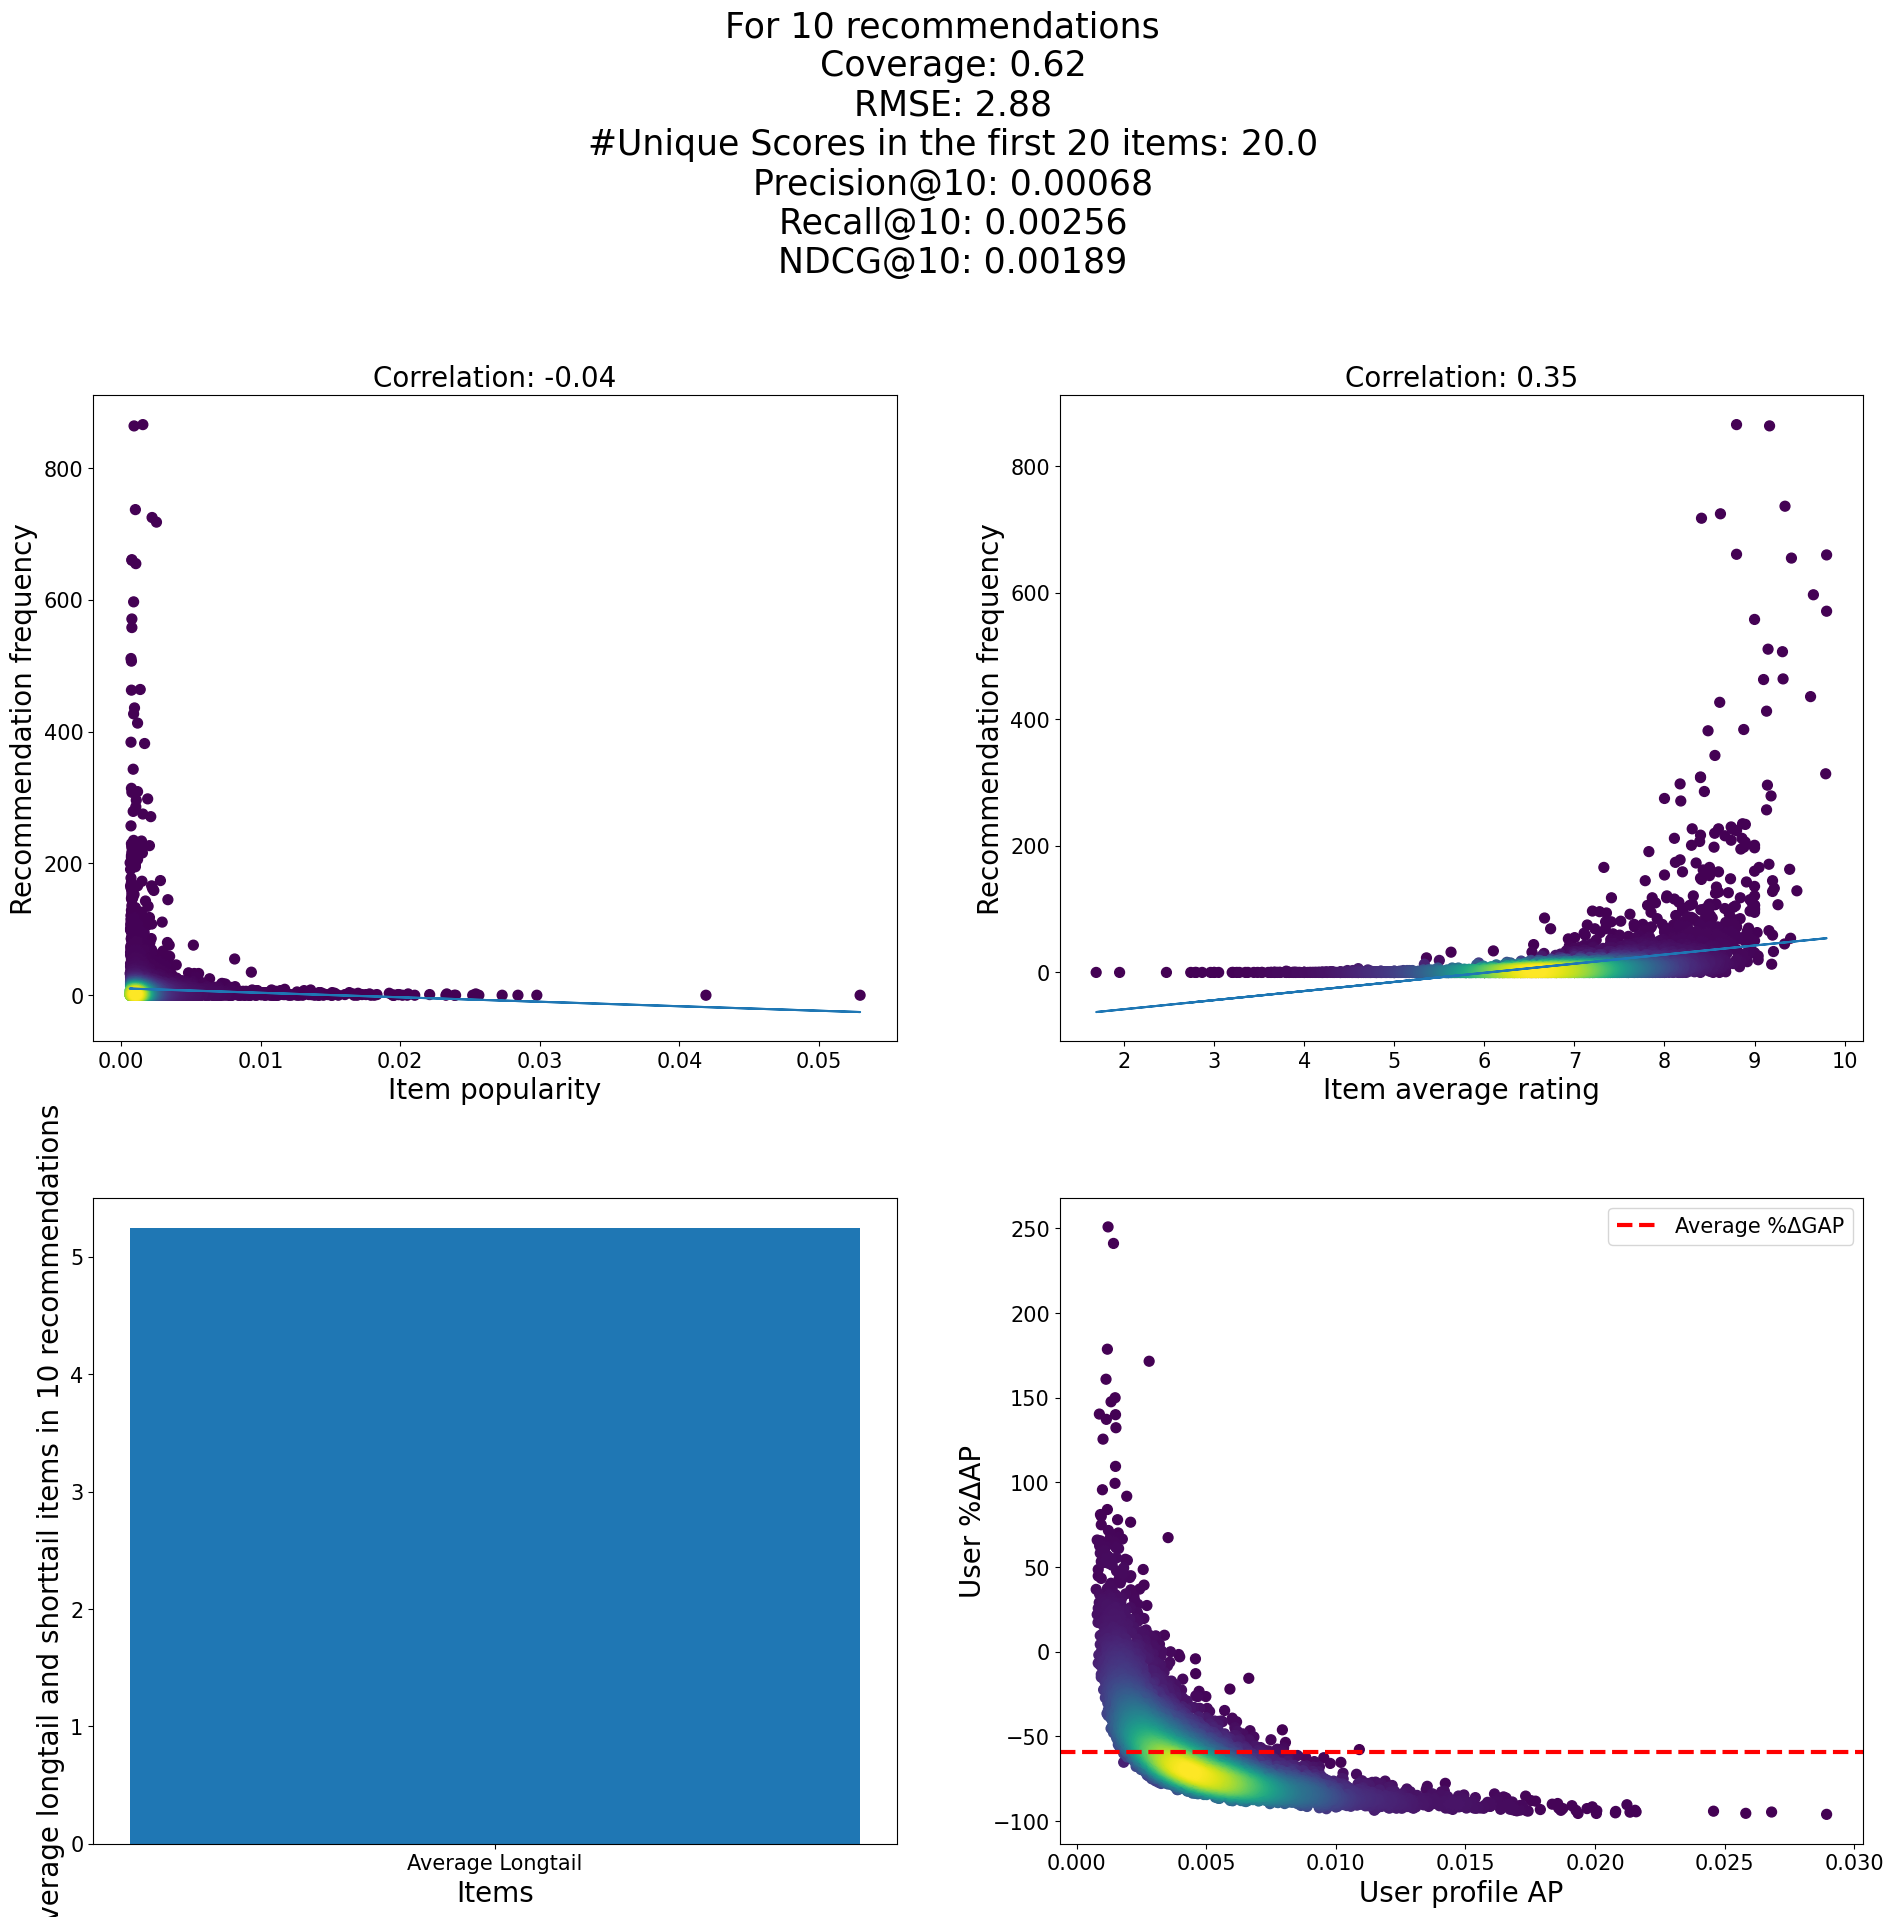

In [8]:
# choose algorithm
algorithm_lkpy = als.BiasedMF
algo_name = "MF"
versions = algo_versions[algo_name]

# for every data strategy
for i in range(len(data_strategies)):
    data_strategy = data_strategies[i]
    # generate the data
    ratings = generate_data(
        strategy=data_strategy, copying_dataset=fairbook_ratings, user_perc=0.2
    )

    # for every 'fixed' version of the algorithm
    for args in versions:
        print(data_strategy, args)

        p = "best_parameters/" + algo_name + "/" + data_strategy + "_" + str(args) + ".pkl"
        if os.path.isfile(p):
            print("We got them already")
            with open(p, "rb") as f:
                best_params = pickle.load(f)
        else:
            print("We have to compute them now")
            # optimize for this fixed version
            best_params = optimize_lkpy(
                ratings=ratings, algorithm_name=algo_name, args=args, max_evals=20, partition_way = 'row'
            )
    
            # save the best parameters for this fixed version
    
            with open(
                "best_parameters/"
                + algo_name
                + "/"
                + data_strategy
                + "_"
                + str(args)
                + ".pkl",
                "wb",
            ) as f:
                pickle.dump(best_params, f)

        
        # # optimize for this fixed version
        # best_params = optimize_lkpy(
        #     ratings=ratings,
        #     algorithm_name=algo_name,
        #     args=args,
        #     partition_way="row",
        #     max_evals=20,
        # )

        # # save the best parameters for this fixed version

        # with open(
        #     "best_parameters/"
        #     + algo_name
        #     + "/"
        #     + data_strategy
        #     + "_"
        #     + str(args)
        #     + ".pkl",
        #     "wb",
        # ) as f:
        #     pickle.dump(best_params, f)

        reg_list = [0, 0.001, 0.01, 0.1]
        features_list = [10, 50, 100]
        optimal_reg = reg_list[best_params["reg"]]
        optimal_features = features_list[best_params["features"]]

        # run the training and evaluation for the fixed version + the best other parameters
        pop_biases_lkpy, metrics_dict_lkpy = modelling_mf.train_algorithm(
            algorithm=lambda: algorithm_lkpy(
                features=optimal_features, reg=optimal_reg, bias=args["bias"]
            ),
            algo_name=algo_name,
            ratings=ratings,
            evaluation_way=evaluation_way,
            verbose=verbose,
            n=nr_recs,
            sampling_strategy=sampling_strategy,
            partition_way=partition_way,
            plot=plot,
            data_strategy=data_strategy,
            args=args,
            save_plot=save_plot,
        )

        # Save metrics!
        with open(
            "experimental_results/"
            + algo_name
            + "/"
            + data_strategy
            + "_"
            + str(args)
            + ".pkl",
            "wb",
        ) as f:
            pickle.dump(metrics_dict_lkpy, f)
        with open('experimental_results/'+algo_name+'/detailed_per_item_'+data_strategy+'_'+str(args)+'.pkl', 'wb') as f:
            pickle.dump(pop_biases_lkpy, f)

## Optimize, train, evaluate Cornac
- **Algorithm**
- **Fixed parameters**
- **To-optimize parameters**

In [12]:
algo_versions = {"CornacMF": [{"bias": True}, {"bias": False}]}

In [ ]:
algorithm_cornac = MF
algo_name = "CornacMF"
versions = algo_versions[algo_name]

# for every data strategy
for i in range(len(data_strategies)):
    data_strategy = data_strategies[i]
    # generate the data
    ratings = generate_data(
        strategy=data_strategy, copying_dataset=fairbook_ratings, user_perc=0.2
    )
    # for every 'fixed' version of the algorithm
    for args in versions:
        print(data_strategy, args)


        p = "best_parameters/" + algo_name + "/" + data_strategy + "_" + str(args) + ".pkl"
        if os.path.isfile(p):
            print("We got them already")
            with open(p, "rb") as f:
                best_params = pickle.load(f)
        else:
            print("We have to compute them now")
            # optimize for this fixed version
            best_params = optimize_cornac(
                ratings=ratings, algorithm_name=algo_name, args=args, max_evals=20
            )
    
            # save the best parameters for this fixed version
    
            with open(
                "best_parameters/"
                + algo_name
                + "/"
                + data_strategy
                + "_"
                + str(args)
                + ".pkl",
                "wb",
            ) as f:
                pickle.dump(best_params, f)
                
        # # optimize for this fixed version
        # best_params = optimize_cornac(
        #     ratings=ratings, algorithm_name=algo_name, args=args, max_evals=20
        # )

        # # save the best parameters for this fixed version

        # with open(
        #     "best_parameters/"
        #     + algo_name
        #     + "/"
        #     + data_strategy
        #     + "_"
        #     + str(args)
        #     + ".pkl",
        #     "wb",
        # ) as f:
        #     pickle.dump(best_params, f)

        optimal_k = best_params["k"]
        optimal_reg = best_params["lambda_reg"]
        optimal_lr = best_params["learning_rate"]

        pop_biases_cornac, metrics_dict_cornac = modelling_mf.train_algorithm_cornac(
            algorithm=lambda: algorithm_cornac(
                k=optimal_k,
                use_bias=args["bias"],
                lambda_reg=optimal_reg,
                learning_rate=optimal_lr,
            ),
            algo_name=algo_name,
            ratings=ratings,
            evaluation_way=evaluation_way,
            verbose=verbose,
            n=nr_recs,
            sampling_strategy=sampling_strategy,
            partition_way=partition_way,
            plot=plot,
            data_strategy=data_strategy,
            args=args,
            save_plot=save_plot,
        )

        # Save metrics!
        with open(
            "experimental_results/"
            + algo_name
            + "/"
            + data_strategy
            + "_"
            + str(args)
            + ".pkl",
            "wb",
        ) as f:
            pickle.dump(metrics_dict_cornac, f)
        with open('experimental_results/'+algo_name+'/detailed_per_item_'+data_strategy+'_'+str(args)+'.pkl', 'wb') as f:
            pickle.dump(pop_biases_cornac, f)

uniformly_random {'bias': True}
We got them already

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 2.8802 |    0.2489 |   0.0535

